<font size="6">**KNN con python e scikit-learn**</font><br>

> (c) 2025 Antonio Piemontese


# La rilevazione dell'ambiente
**Il presente notebook funziona sia in Jupyter Notebook che Google Colab**.
A questo scopo, per garantire la compatibilit√† di alcune celle di codice con entrambi gli ambienti indicati, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab): la seguente cella imposta una **variabile booleana `IN_COLAB`** che sar√† poi **testata** da alcune celle del notebook (in particolare quelle di visualizzazione di immagini e PDF) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [95]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Siamo in Colab:", IN_COLAB)

Siamo in Colab: False


# Import dei package per la visualizzazione di immagini e PDF

In [96]:
# package necessari per la VISUALIZZAZIONE delle IMMAGINI e dei PDF (necessari sia in JN che in Colab):
# IPython.display √® la cassetta degli attrezzi di Jupyter/Colab per mostrare contenuti ricchi (immagini, HTML, iframe, audio, video, ecc.)
# direttamente nell‚Äôoutput della cella. Per maggiori info al riguardo vedi il notebook di introduzione a Google Colab.
from IPython.display import Image, display,IFrame


import os                                           # necessario a Google Colab per vedere da una cella codice
                                                    # i contenuti del 'content'

if IN_COLAB:
  from google.colab import files

**Pro del KNN**:
* √® un algoritmo **semplice** da capire e facilmente spiegabile ad un cliente/collega/committente
* da studi empirici seri, risulta che il knn √® il miglior algoritmo, cio√® quello che fornisce le migliori previsioni, in ben un **terzo dei casi**

**Limiti del KNN**
* **non crea un modello** e quindi ha bisogno di **molti dati in input (righe)**; cio√®, in altre parole, lo spazio dei predittori deve essere molto **denso** in modo che, ovunque si trovi il nuovo punto da prevedere, esso abbia dei vicini (*neighbours*). La densit√† del dataset di training, ancorch√® non sia misurabile in modo oggettivo, √® data dalla presenza di tutte o la maggior parte delle possibili combinazioni dei valori dei predittori/feature (nel dataset di training). NB. Il KNN NON ci avverte se lo spazio (dei predittori) non √® denso (cio√® √® 'sparso') nel senso che esso comunque funziona, il "vicinato" sar√† costituito non dai k punti pi√π vicini ma dai k punti meno lontani, che per√≤, in quanto tali, non √® detto che siano *rappresentativi*.
* per la ragione di cui sopra, √® un algoritmo **pi√π lento** computazionalmente di altri

# Il KNN spiegato in modo grafico

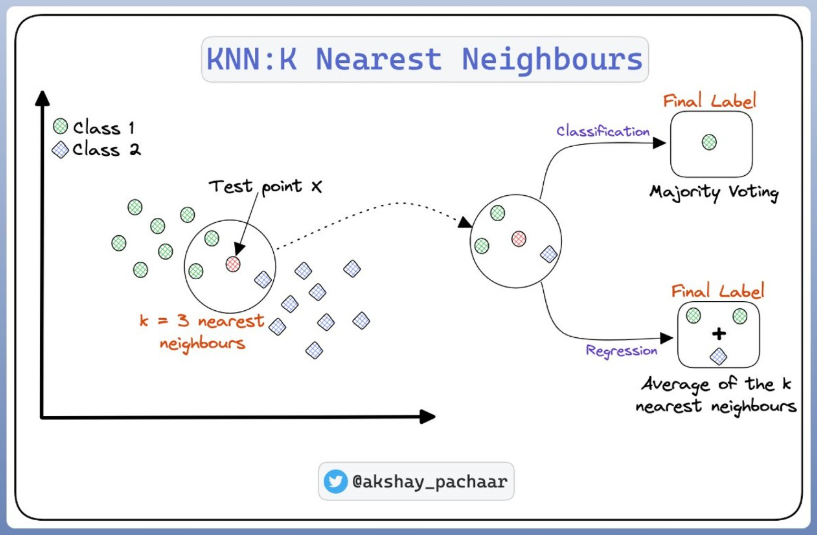

In [97]:
Image('knn_graphically_explained.png') if IN_COLAB else display(Image(filename='knn_graphically_explained.png'))

# KNN in scikit-learn

Primo passo: l'installazione di *scikit-learn* con il solito comando *pip*.

Per seconda cosa importiamo tutti i package cher ci servono.<br>
E' buona norma importare tutti i package **all'inizio** del notebook, come una delle prima celle. Da un punto di vista tecnico, √® sufficiente importare un package prima della cella che lo richiama, e quindi importarli nel notebook poco per volta.

In [98]:
import pandas as pd
import numpy as np

# sklearn, abbreviazione di scikit.learn, √® un kit composto da molti package (ed anche dataset), dal quale possiamo quindi
# estrarre i singoli package di nostro interesse.
# non vogliamo importare (cio√® caricare in memoria) tutti i package di sklearn, perch√® occuperebbero inutilmente tanta memoria.

from sklearn import datasets                          # sklearn is part of scikit-learn (so 46113732)
from sklearn.datasets import load_iris                # il metodo di caricamento del dataset iris
from sklearn.neighbors import KNeighborsClassifier    # il classificatore knn
from sklearn.neighbors import KNeighborsRegressor     # NON utilizzato in questo notebook
from sklearn import metrics                           # le metriche per valutare la capacit√† predittiva degli algoritmi
from sklearn.model_selection import train_test_split  # il package per suddividere il dataset in training e test
from sklearn import preprocessing                     # un package specifico per la pre-elaborazione dei dati
from sklearn.preprocessing import LabelEncoder        # per convertire le label in interi

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV # 3 package per la cross-validazione

# alcune utility per la regressione: prima installare 'dmba' da prompt anaconda (pip install dmba)
from dmba import regressionSummary
from dmba import adjusted_r2_score

Carichiamo il dataset `iris` da scikit-learn (non c'√® un file 'iris.csv)

In [99]:
iris = load_iris()              # √® un oggetto 'bunch', inclusivo di documentazione. Non √® ancora un df pandas.
print(type(iris.data))

<class 'numpy.ndarray'>


In [6]:
iris.data.shape

(150, 4)

In [7]:
print(iris.data)                # le variabili di previsione, aka, feature, predittori, variabili indipendenti, dimensioni,
                                # assi di analisi, colonne, attributi

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [8]:
print(iris.target)  # i valori della risposta

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [9]:
print(iris.target_names)  # lo schema di decodifica della risposta

['setosa' 'versicolor' 'virginica']


In [10]:
print(iris.DESCR)   # non usare la funzione 'display' perch√® relativa ai dataframe, ma iris √® un oggetto 'bunch'

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Quanto ora visto (con *iris*) vale solo con gli oggetti di classe `bunch`. Normalmente, i dataset sono caricati da file esterno, ad esempio *csv* con la funzione di pandas `pd.read_csv`.

## La costruzione del modello
Strettamente parlando, l'algoritmo `knn` non ha un modello predefinito.<br>
Occorrono alcuni passi, gli stessi per tutti gli algoritmi predittivi di *scikit-learn*:
1. **creare un oggetto** della classe `KNeighborsClassifier`; nel gergo della programmazione ad oggetti, un oggetto deve essere *istanziato*, cio√® creato, prima di poterlo usare. E' qui che si definiscono i **parametri** del modello.
2. suddividere le colonne del dataset in **X** (i predittori) ed **y** (la risposta); √® uno standard del ML che ha delle ragioni matematiche
3. fare il **fit** dell'algoritmo ai dati (in italiano, si dice *adattamento*); √® in questo step che passiamo i dati (predittori e risposte separatamente)
4. fare le **pseudo-previsioni** (cio√® fatte sui dati di allenamento - √® un errore, vedi pi√π avanti) con il metodo `predict`
5. ed infine, calcolare lo `accuracy_score`, vedi [qui](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.accuracy_score.html), che √® un numero compreso tra 0 ed 1 e rappresenta la percentuale di previsioni corrette (sul totale). Pi√π il valore √® vicino a 1, meglio √®.

> L'**idea base** del ML √® di: scegliere un algoritmo (predittivo) tra i molti disponibili, adattarlo ai dati (*fitting*), misurare le capacit√† predittive del modello (il modello √® il risultato del fitting). In altre parole:<br>
dati (di allenamento) --> applicazione dell'algoritmo ai dati (di allenamento) --> modello --> applicazione del modello ai dati (di test) --> misure della capacit√† predittiva del modello (sui dati di test) --> applicazione del modello a NUOVI dati (dei quali NON conosciamo la risposta).<br>
Per i dati di allenamento e di test conosciamo la risposta (perch√® sono passati, storici).<br>
NB. Il KNN √® pigro, e dunque non crea il modello.

In [11]:
model = KNeighborsClassifier(n_neighbors=1)        # costruzione con k=1 dell'oggetto (in knn NON c'√® un modello
                                                   # in senso stretto)
                                                   # in questo algoritmo di scikit-learn, il parametro *K* √® detto  `n_neighbors`
                                                   # iniziamo con K=1.
model

KNeighborsClassifier(n_neighbors=1)

In [12]:
type(model)

sklearn.neighbors._classification.KNeighborsClassifier

In [13]:
X = iris.data
y = iris.target

In [14]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [15]:
model.fit(X,y)  # il fit con gli argomenti X ed y (i dati)
                # il risultato del fit NON √® immediatamente visibile, o meglio √® memorizzato nell'oggetto di tipo KNN, cio√®
                # in questo nell'oggetto 'model'.
                # In cosa consiste? Nel caso del KNN il metodo di fit si limita a caricare i dati (cio√® X ed y) nell'oggetto

KNeighborsClassifier(n_neighbors=1)

In [16]:
y_pred = model.predict(X)                          # la pseudo-previsione dei nuovi valori

In [17]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [19]:
metrics.accuracy_score(y,y_pred)

1.0

Come √® possibile? un modello che prevede sempre correttamente?<br>
**Errore di fondo (concettuale)**: training e valutazione (test) sono stati fatti sullo stesso dataset.<br>
Inoltre, il dataset iris √® ben separato.

Per maggiori informazioni sulle metriche di valutazione di un algoritmo predittivo vedi [qui](https://scikit-learn.org/stable/modules/model_evaluation.html). Questa metrica - cio√® `accuracy_score` - √® anche spesso chiamata **accuracy** (*accuratezza*).

Vediamo ora perch√® ed il modo giusto, come descritto anche [qui](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html).

## La valutazione del modello (fatta in modo corretto)
Non si pu√≤ valutare la capacit√† predittiva di un algoritmo (con le metriche prima viste ed altre ancora) sugli stessi dati sui quali √® stato allenato.<br>
Serve un dataset NUOVO dedicato alla valutazione dell'algoritmo, chiamato in vari modi:
* **test** dataset
* **validation** dataset
* hold-out dataset
* out-of-sample dataset
* new, unseen dataset
* "designated in advance dataset (ISLR)"
Il problema √® che non ce l'abbiamo. Noi abbiamo solo e soltanto le 150 righe di `iris`.

Allora possiamo fare cos√¨: suddividere *iris* in training e test.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
                                                       # Il `test_size` tipicamente vale 0.3 - 0.25.
                                                       # La suddivisione √® casuale, e pertanto serve il seme.

In [21]:
type(X_train) # scikit-learn lavora (come input) con array NUMERICHE numpy o matrici NUMERICHE SPARSE di scipy

numpy.ndarray

In [22]:
X_train.shape

(105, 4)

In [23]:
X_test.shape

(45, 4)

In [24]:
y_train.shape

(105,)

In [25]:
y_test.shape

(45,)

Eseguiamo ora gli stessi passi descritti nella precedente sezione. L'oggetto si chiama ora `knn_classifier`.

In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=20) # costruzione di un classificatore 1-NN (vuoto, senza ancora i dati).
                                                     # √® il famoso metodo COSTRUTTORE che, per ogni classe OO, crea la
                                                     # nuova istanza (oggetto).
                                                     # k √® l'iper-parametro (cio√® il parametro di tuning);
                                                     # pi√π esattamente, l'iper-parametro √® N/k (ESL, p. 15)

# "Objects in python are created by calling a special type of method in the class known as a constructor."

In [27]:
knn_classifier

KNeighborsClassifier(n_neighbors=20)

In [28]:
knn_classifier.fit(X_train,y_train) # store dei dati di training (knn √® un metodo non-parametrico instance-based)
                                    # √® una pseudo-fit, per rispettare la struttura fit-predict-transform di scikit-learn.

                                    #######################################################################################
                                    # The training phase of the algorithm KNN consists only of storing the feature vectors#
                                    # and class labels of the training samples.                                           #
                                    #######################################################################################

KNeighborsClassifier(n_neighbors=20)

In generale, dopo il fit, √® possibile vedere gli **attributi** (il termine di *scikit-learn* per indicare l'output del fit) da non confondere con gli argomenti (gli input ai metodi), chiamati in *scikit-learn* **parametri**. Il nome degli attributi per convenzione di scikit-learn terminano sempre con '*_*'<br>
Per l'elenco degli attributi disponibili, in questo caso, si pu√≤ vedere la documentazione della classe `KNeighborsClassifier`. Nel caso del KNN, gli attributi (valorizzati dal fit) non hanno particolare significato (ci forniscono delle informazioni gi√† note), ma in altri algoritmi (ad esempio gli alberi di decisione) non sar√† cos√¨.

In [29]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(
 |      n_neighbors=5,
 |      *,
 |      weights='uniform',
 |      algorithm='auto',
 |      leaf_size=30,
 |      p=2,
 |      metric='minkowski',
 |      metric_params=None,
 |      n_jobs=None
 |  )
 |
 |  Classifier implementing the k-nearest neighbors vote.
 |
 |  Read more in the :ref:`User Guide <classification>`.
 |
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by 

In [30]:
knn_classifier.classes_

array([0, 1, 2])

In [31]:
knn_classifier.n_features_in_   # "feature" significa "predittore"

4

In [32]:
knn_classifier.feature_names_in_   # --> non funziona perch√® il dataset X che abbiamo fornito in input al metodo  di fit
                                   #     √® un'array numpy SENZA i nomi delle colonne

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_names_in_'

Invochiamo ora il metodo di `predict` sui dati di test. Questo metodo NON ha attributi (output), restituisce i risultati come "return" (vedi help) e quindi occorre assegnare il vettore di previsioni (l'output) ad un nostro vettore, in questo caso `y_pred`.

In [33]:
y_pred = knn_classifier.predict(X_test) # la previsione dei nuovi valori

In [34]:
y_pred

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1])

In [35]:
y_test      # le y vere

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1])

In [36]:
print("Accuratezza: ", np.round(metrics.accuracy_score(y_test,y_pred),2)) # confronto le risposte effettive (actual)
                                                                          # vs quelle previste - sui dati di TEST

Accuratezza:  0.98


> Morale: abbiamo una indicazione numerica della capacit√† predittiva dell'algoritmo KNN applicato a questo dataset.<br>
> In genere, quasi sempre, l'accuratezza sui dati di test √® INFERIORE a quella sui dati di training.<br>
> 2 casi:<br>
> l'accuratezza di test √® alta e ci conforta: ci√≤ pu√≤ dipendere da molti elementi, non ultimo la natura del dataset;<br>
> in caso di scarto ampio tra l'accuratezza di training e quella di test, con la seconda bassa, cosa fare? Ci sono almeno cinque possibili motivi:
> 1. il modello √® andatto in overfitting (sovra-adattamento) - vedi slide - bisogna campiare gli iper-parametri (quelli definiti alla creazione dell'istanza, ad es il valore di K)
> 2. provare con un altro algoritmo
> 3. il dataset ha un numero di righe sufficiente perch√® l'algoritmo possa imparare e testare? --> campionare / raccogliere altre righe
> 4. manca uno o pi√π predittori importanti
> 5. l'ipotesi peggiore: non c'√® una relazione abbastanza significativa tra i predittori e la risposta, la casualit√† potrebbe giocare un grande ruolo nel fenomeno in oggetto. In questo caso, il ML non √® utile.

Siamo ora pronti a fare le previsioni NON su un dataset di test (per il quale conosciamo le risposte) ma su NUOVE righe, in questo modo:

In [37]:
# VERE previsioni con i dati di 3 NUOVI fiori iris:
new_data = [[5,5,3,2],[2,4,3,5],[3,4,4,4]]    # una lista
                                              # <-- notare la DOPPIA parentesi, anche per una sola riga!!
                                              #     serve a creare una lista NESTED (e non ENUMERATED)
print(type(new_data))
print(new_data)

<class 'list'>
[[5, 5, 3, 2], [2, 4, 3, 5], [3, 4, 4, 4]]


> Nel metodo `predict` di *scikt-learn* occorre usare un dataframe oppure una lista **nested**, definita con le doppie [[]], eventualmente convertita in una array numpy 2D.

In [38]:
new_preds = knn_classifier.predict(new_data)    # questo ogetto knn √® stato costruito sul dataset di training;
                                                # in realt√†, l'uso pi√π comune √® quello, una volta accertata l'accuratezza
                                                # del metodo sul test set, di RICOMPORRE il training e test set e RIESEGUIRE
                                                # il fit sul dataset COMPLETO, allo scopo di utilizzare il maggior numero
                                                # possibile di righe.
print(new_preds) # le tre classi previste

[0 1 1]


In [39]:
# rendiamole pi√π leggibili:
pred_species = [iris.target_names[p] for p in new_preds] # "list comprehension" (alternativo ad una for)
pred_species

[np.str_('setosa'), np.str_('versicolor'), np.str_('versicolor')]

In [40]:
for p in new_preds:                     # ciclo classico (alternativo alla list comprehension)
    print(iris.target_names[p])

setosa
versicolor
versicolor


Le previsioni degli algoritmi / modelli di ML sono probabilistiche.

In [41]:
knn_classifier.predict_proba(new_data)

array([[0.5 , 0.5 , 0.  ],
       [0.05, 0.65, 0.3 ],
       [0.  , 0.55, 0.45]])

In [42]:
# per problemi di classificazione multi-classe (k>2, dove qui k √® il numero di classi della risposta e NON la dimensione
# del vicinato):
# - alcuni algoritmi di ML (knn, SVM, ecc) usano lo schema One vs All (OVA), aka One vs Rest (OvR), che permette di costruire
#   solo k classificatori OvA (uno per classe, detta "classe di interesse", che √® la classe positiva, mentre tutte le altre sono
#   considerate negative) anzich√® costruire (k over 2) classificatori binari;
# - altri metodi di ML, invece, forniscono di loro (nativamente) le probabilit√† delle varie singole classi (ad es. LDA o
#   Naive Bayes)

**One vs All**:

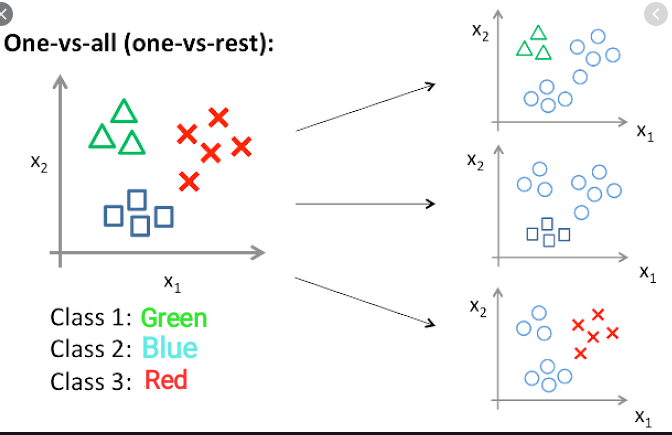

In [43]:
Image('OvA.png') if IN_COLAB else display(Image(filename='OvA.png'))

In [44]:
# e le probabilit√†? tutti i metodi di classificazione di scikit-learn hanno il metodo 'predict_proba' per la
# 'probabilistic classification'
print(knn_classifier.predict_proba(X_test)[0:10,0]) # il vettore della probabilit√† di 0 per le prime 10 righe del dataset di test
print(knn_classifier.predict_proba(X_test)[0:10,1]) # il vettore della probabilit√† di 1 per le prime 10 righe del dataset di test
print(knn_classifier.predict_proba(X_test)[0:10,2]) # il vettore della probabilit√† di 2 per le prime 10 righe del dataset di test


[1.   0.05 0.   1.   0.   0.   0.   1.   1.   0.  ]
[0.   0.9  0.75 0.   0.   0.6  0.1  0.   0.   0.  ]
[0.   0.05 0.25 0.   1.   0.4  0.9  0.   0.   1.  ]


In [45]:
print(knn_classifier.predict_proba(X_test)[5,0])
print(knn_classifier.predict_proba(X_test)[5,1])
print(knn_classifier.predict_proba(X_test)[5,2])

0.0
0.6
0.4


In [46]:
print(knn_classifier.predict(X_test)[5])

1


[esempio istruttivo](https://stackoverflow.com/questions/37089177/probability-prediction-method-of-kneighborsclassifier-returns-only-0-and-1)

Chi ha detto che K=1 sia il miglior valore?<br>
Adesso proviamo a modificare i valori di alcuni parametri (gli argomenti in input al costruttore).

In [47]:
knn = KNeighborsClassifier(n_neighbors=25, algorithm='ball_tree', metric='euclidean') # k=25 (cio√® aumento la dimensione
                                                                                      # del vicinato)
knn.fit(X_train, y_train)

print(knn.predict_proba(X_test)[:,:][0:10])

[[1.   0.   0.  ]
 [0.2  0.76 0.04]
 [0.   0.76 0.24]
 [1.   0.   0.  ]
 [0.   0.04 0.96]
 [0.   0.56 0.44]
 [0.   0.16 0.84]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   0.04 0.96]]


Le probabilit√† dei vari fiori sono ora anche differenti da 0 od 1. Questo perch√® abbiamo ampliato la dimensione del vicinato, e dunque esso pu√≤ essere "misto". Con K=1, ovviamente, il viccino era necessariamente o 0,oppure 1, oppure 2.

In [48]:
knn.params_                                  # ERRORE! giusto! un metodo NON-parametrico, come appunto il knn, per definizione
                                             # NON ha parametri

AttributeError: 'KNeighborsClassifier' object has no attribute 'params_'

> Ancorch√® KNN sia un algoritmo pigro, √® importante suddividere il dataset in training e test - vedi [questa risposta di chatGPT](https://chatgpt.com/share/671a3a9f-6cc8-8012-9cae-f5a1cee4b2cc)

## Dati di input agli stimatori di scikit-learn

In [49]:
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= list(iris['feature_names']) + ['target'])
type(df)
                     # come gi√† visto prima:
                     # "To convert a scikit-learn dataset to a pandas dataset you can use the pd.DataFrame constructor, giving
                     # a numpy array (data) and a list of the names of the columns (columns). To have everything in one
                     # DataFrame, you can concatenate the features and the target into one numpy array with np.c_[...]
                     # (note the []).

pandas.core.frame.DataFrame

In [50]:
# cambiamo i nomi delle variabili (senza i cm) - con 'inplace=True'
df.rename(columns={'sepal length (cm)': 'sepal length', 'sepal width (cm)': 'sepal width','petal length (cm)': 'petal length','petal width (cm)': 'petal width'},inplace=True)

In [51]:
df

sepal length  sepal width  petal length  petal width  target
0             5.1          3.5           1.4          0.2     0.0
1             4.9          3.0           1.4          0.2     0.0
2             4.7          3.2           1.3          0.2     0.0
3             4.6          3.1           1.5          0.2     0.0
4             5.0          3.6           1.4          0.2     0.0
..            ...          ...           ...          ...     ...
145           6.7          3.0           5.2          2.3     2.0
146           6.3          2.5           5.0          1.9     2.0
147           6.5          3.0           5.2          2.0     2.0
148           6.2          3.4           5.4          2.3     2.0
149           5.9          3.0           5.1          1.8     2.0

[150 rows x 5 columns]

In [52]:
# features/target
X = df[['sepal length', 'sepal width', 'petal length', 'petal width']]    # anzich√® iris.data dell'oggetto 'bunch'
y = pd.Series(iris.target)

# modello
knn_classifier = KNeighborsClassifier(n_neighbors=3).fit(X, y)

# nuovi campioni
new_sample_data = [[1,2,3,4],[2,4,1,6],[4,2,1,3]]                         # una nuova lista (senza i nomi colonna)

# si usano le STESSE colonne di X
new_sample_df = pd.DataFrame(new_sample_data, columns=X.columns)          # √® meglio convertire i dati in un dataframe pandas che ha anche i nomi colonne

# predict senza errori n√© warning
new_preds = knn_classifier.predict(new_sample_df)
print(new_preds)

[1 0 0]


In [53]:
y = df['target']                                          # anzich√® iris.target dell'oggetto 'bunch'
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

In [54]:
# nb. se INVECE (erroneamente):
y = np.ravel(df[['target']])                 # un dataframe convertito in un vettore 1D (senza 'ravel' c'√® un warning)
print(type(df[['target']]))
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X,y)            # errore! ("A column-vector y was passed when a 1d array was expected")

<class 'pandas.core.frame.DataFrame'>


KNeighborsClassifier(n_neighbors=3)

## Modello non-parametrico
Il knn √® un algoritmo **non-parametrico** perch√® <u>NON crea il modello</u>, a differenza della maggior parte degli altri algoritmi (CART, foreste, regressione, ecc). Il "lavoro" √® fatto al momento della *predict*, nel quale l'algoritmo calcola le distanze (euclidee?) della riga da prevedere rispetto a tutte le altre righe, ottiene cos√¨ un vettore delle distanze, considera le righe con le k minori distanze (dove k √® il parametro principale del KNN, quello che gli d√† il nome) e poi classifica la nuova riga in base alla classe maggioritaria del vicinato oppure prevede la risposta numerica della nuova riga in base alla media o mediana delle risposte del vicinato.<br>
Ne consegue che, nel KNN, il metodo pi√π lento da un punto di vista computazionale √® la *predict* e non la *fit* (come invece avviene per gli altri algoritmi.<br>
> Per conformit√† con le altre classi *estimator* di *scikit-learn*, anche le classi  `KNeighborsClassifier` e `KNeighborsRegressor` hanno il metodo *fit*, che tuttavia appunto NON crea il modello ma si limita a memorizzare nell'oggetto (istanziato dal costruttore) le **coordinate** di tutte le righe di training.

## Persistenza del modello

In [55]:
import joblib  # verificare che il package 'joblib' sia stato precedentemente installato (con pip install joblib)
               # so: 61893719

               # In the specific case of scikit-learn, it may be better to use joblib‚Äôs replacement of pickle (dump & load),
               # which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted
               # scikit-learn estimators.

Salviamo ora il modello `knn_classifier` tramite il metodo `dump` della classe `joblib` fornendo in input il modello ed il nome del file (nel quale salvare il modello):

In [56]:
joblib.dump(knn_classifier,'classificatore_knn.joblib')  # --> salva nella directory corrente

['classificatore_knn.joblib']

In [57]:
%ls

 Il volume nell'unit√† C √® OS
 Numero di serie del volume: 7E81-0BB8

 Directory di C:\Users\Utente\Desktop\salvataggi\SALVATAGGIO DATI\Documents\Seminari\Data Science (corsi)\Corso ML con Python (Overnet - Aresys)

17/10/2025  09:12    <DIR>          .
17/10/2025  09:12    <DIR>          ..
16/10/2025  17:54    <DIR>          .ipynb_checkpoints
08/06/2025  20:49         2.210.293 .log
26/05/2021  19:44           233.922 03_17.png
26/05/2021  21:29           145.047 03_21.png
25/09/2021  17:08    <DIR>          03_21_files
17/10/2023  16:03           186.561 10_most_important_python_libraries_for_DS.png
15/05/2024  12:18         2.863.152 11 Types of Variables in a Dataset - by Avi Chawla.pdf
11/05/2024  16:06         5.763.851 15 Pandas ? Polars ? SQL ? PySpark Translations.pdf
08/07/2024  14:39         3.907.516 3 Types of Missing Values - by Avi Chawla.pdf
02/07/2024  15:32         2.710.877 5 Cross Validation Techniques Explained Visually.pdf
18/05/2024  16:28         7.079.277 5 

In [58]:
del knn_classifier # cancellazione del classificatore
import gc          # 'gc' sta per 'garbage collector'
gc.collect()       # quando √® lecito fare la garbage collection? (so: 478167)
                   # con i big data, altrimenti non √® necessario (DMforBA, p. 45).

805

In [59]:
knn_classifier.predict(sample_data)  # --> oggetto inesistente, ora

NameError: name 'knn_classifier' is not defined

In [60]:
knn_classifier = joblib.load('classificatore_knn.joblib') # load dell'oggetto

In [61]:
knn_classifier.predict(new_sample_df)

array([1., 0., 0.])

## knn sul *german credit*

### Caricamento e preparazione dei dati
Useremo il famoso dataset `german_credit`, relativo a richieste di prestito fatte da vari clienti ad una banca tedesca negli anni '90. I dati sonopoi stati "aggiustati" da un professore universitario tedesco.<br>
Non √® un dataset politicamente corretto.

In [121]:
# Importing the data
df_credit = pd.read_csv("german_credit_data.csv",index_col=0)
df_credit.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [123]:
df_credit.head(10)

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   
5   35    male    1    free             NaN              NaN           9055   
6   53    male    2     own      quite rich              NaN           2835   
7   35    male    3    rent          little         moderate           6948   
8   61    male    1     own            rich              NaN           3059   
9   28    male    3     own          little         moderate           5234   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  
5        36            education  good  
6        24  furniture/equipment  good  
7        36                  car  good  
8        12             radio/TV  good  
9        30                  car   bad

In [124]:
df_credit.shape

(1000, 10)

In [125]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [127]:
df_credit['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

Alcune colonne (`Saving accounts`, `Checking account`) hanno **valori nulli**, √® meglio toglierli, possono infastidire il fit.

In [128]:
df_credit = df_credit.dropna()

In [130]:
df_credit['Risk'].value_counts()   # il drop delle righe con NaN/MV ha alterato le proporzioni di base, √® comunque un dataframe bilanciato

Risk
good    291
bad     231
Name: count, dtype: int64

Questo dataframe, come la maggiorparte dei dataframe, ha **un misto di colonne numeriche e categoriche** (e poi altre colonne stringa o data, ecc). I predittori categorici devono essere "dummizzate". Nel dataset *iris*, invece, che √® molto semplice, i 4 predittori erano tutti numerici.

In [67]:
display(df_credit['Housing'].unique())
display(df_credit['Housing'].value_counts())

array(['own', 'free', 'rent'], dtype=object)

Housing
own     349
rent    108
free     65
Name: count, dtype: int64

In [68]:
display(df_credit['Purpose'].value_counts())

Purpose
car                    173
radio/TV               132
furniture/equipment    107
business                53
education               28
repairs                 14
vacation/others          9
domestic appliances      6
Name: count, dtype: int64

In [69]:
display(df_credit['Checking account'].value_counts())

Checking account
little      245
moderate    224
rich         53
Name: count, dtype: int64

In [70]:
# dividiamo le variabili in due gruppi  (mere liste di colonne):
predictors = df_credit.columns.drop('Risk')
outcome = 'Risk'  # a volte chiamato 'risposta' oppure 'target'

In [71]:
df_credit[predictors]

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
1     22  female    2     own          little         moderate           5951   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
7     35    male    3    rent          little         moderate           6948   
9     28    male    3     own          little         moderate           5234   
..   ...     ...  ...     ...             ...              ...            ...   
989   48    male    1     own          little         moderate           1743   
993   30    male    3     own          little           little           3959   
996   40    male    3     own          little           little           3857   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              Purpose  
1          48             radio/TV  
3          42  furniture/equipment  
4          24                  car  
7          36                  car  
9          30                  car  
..        ...                  ...  
989        24             radio/TV  
993        36  furniture/equipment  
996        30                  car  
998        45             radio/TV  
999        45                  car  

[522 rows x 9 columns]

### La pre-elaborazione delle variabili

Eseguiamo ora la **dummizzazione** e poi la **standardizzazione**. Le due operazioni possono anche essere **invertite** poich√® operano su **colonne differenti**: la dummizzazione sulle variabili `object`, la standardizzazione sulle variabili numeriche.

In [82]:
X = pd.get_dummies(df_credit[predictors],drop_first=True)   #  X: tante righe e tante colonne --> √® una MATRICE
y = df_credit[outcome]                                      #  y: tante righe ed una sola colonna --> √® un vettore

In [83]:
X

Age  Job  Credit amount  Duration  Sex_male  Housing_own  Housing_rent  \
1     22    2           5951        48     False         True         False   
3     45    2           7882        42      True        False         False   
4     53    2           4870        24      True        False         False   
7     35    3           6948        36      True        False          True   
9     28    3           5234        30      True         True         False   
..   ...  ...            ...       ...       ...          ...           ...   
989   48    1           1743        24      True         True         False   
993   30    3           3959        36      True         True         False   
996   40    3           3857        30      True         True         False   
998   23    2           1845        45      True        False         False   
999   27    2           4576        45      True         True         False   

     Saving accounts_moderate  Saving accounts_quite rich  \
1                       False                       False   
3                       False                       False   
4                       False                       False   
7                       False                       False   
9                       False                       False   
..                        ...                         ...   
989                     False                       False   
993                     False                       False   
996                     False                       False   
998                     False                       False   
999                      True                       False   

     Saving accounts_rich  Checking account_moderate  Checking account_rich  \
1                   False                       True                  False   
3                   False                      False                  False   
4                   False                      False                  False   
7                   False                       True                  False   
9                   False                       True                  False   
..                    ...                        ...                    ...   
989                 False                       True                  False   
993                 False                      False                  False   
996                 False                      False                  False   
998                 False                      False                  False   
999                 False                       True                  False   

     Purpose_car  Purpose_domestic appliances  Purpose_education  \
1          False                        False              False   
3          False                        False              False   
4           True                        False              False   
7           True                        False              False   
9           True                        False              False   
..           ...                          ...                ...   
989        False                        False              False   
993        False                        False              False   
996         True                        False              False   
998        False                        False              False   
999         True                        False              False   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
1                          False              True            False   
3                           True             False            False   
4                          False             False            False   
7                          False             False            False   
9                          False             False            False   
..                           ...               ...              ...   
989                        False              True          

If you use one-hot encoding, read this:

(It might introduce a problem in the dataset)

When we one-hot encode categorical data, we unknowingly introduce perfect multicollinearity.

Multicollinearity arises when two or more features can predict another feature.

As the sum of one-hot encoded features is always 1, it leads to perfect multicollinearity and it can be problematic for models that don't perform well under such conditions.

This is often called the Dummy Variable Trap.

Talking specifically about linear regression, for instance, it is bad because:

In some way, your data has a redundant feature
Regression coefficients aren't reliable in the presence of multicollinearity, etc.
So how to resolve this?

The solution is simple.

Drop any arbitrary feature from the one-hot encoded features.

This instantly mitigates multicollinearity and breaks the linear relationship that existed before.


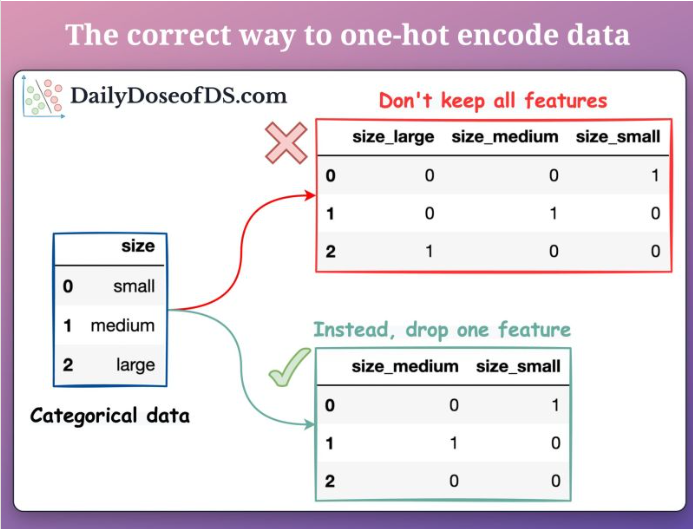

In [84]:
Image('encoding_right.png') if IN_COLAB else display(Image(filename='encoding_right.png'))

Esistono sul web molti articoli e siti sul **one hot encoding**.

In [85]:
print(X.shape, type(X))   # --> un dataframe

(522, 19) <class 'pandas.core.frame.DataFrame'>


In [86]:
X.head()

Age  Job  Credit amount  Duration  Sex_male  Housing_own  Housing_rent  \
1   22    2           5951        48     False         True         False   
3   45    2           7882        42      True        False         False   
4   53    2           4870        24      True        False         False   
7   35    3           6948        36      True        False          True   
9   28    3           5234        30      True         True         False   

   Saving accounts_moderate  Saving accounts_quite rich  Saving accounts_rich  \
1                     False                       False                 False   
3                     False                       False                 False   
4                     False                       False                 False   
7                     False                       False                 False   
9                     False                       False                 False   

   Checking account_moderate  Checking account_rich  Purpose_car  \
1                       True                  False        False   
3                      False                  False        False   
4                      False                  False         True   
7                       True                  False         True   
9                       True                  False         True   

   Purpose_domestic appliances  Purpose_education  \
1                        False              False   
3                        False              False   
4                        False              False   
7                        False              False   
9                        False              False   

   Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
1                        False              True            False   
3                         True             False            False   
4                        False             False            False   
7                        False             False            False   
9                        False             False            False   

   Purpose_vacation/others  
1                    False  
3                    False  
4                    False  
7                    False  
9                    False

In [87]:
print(y.shape, type(y))   # una series

(522,) <class 'pandas.core.series.Series'>


> La *dummizzazione* delle colonne categoriche (dei dataframe sui quali costruiamo i modelli predittivi) √® indispensabile o comunque consigliabile per TUTTI gli algoritmi di ML.

Sul dataset *iris* (molto semplice) i 4 predittori (le due length e le due width) hanno la stessa unit√† di misura (i cm), ma spesso non √® cos√¨, come infatti in `german_credit`.

---
Siccome l'algoritmo *knn* usa le **distanze** per determinare il *vicinato* (neighborhood), occorre necessariamnete **standardizzare i valori dei predittori** prima del fit, per evitare che alcune colonne (con unit√† di misura grande) pesino indebitamente di pi√π di altre colonne nel determinare le distanze delle righe. In proposito si veda la sezione `Preprocessing dei dati` del notebook *A. Introduzione*.<br>
La risposta y invece NON deve essere standardizzata, anche se fosse numerica.

---

In [88]:
std_X = preprocessing.scale(X)             # la funzione 'scale' fa SIA centering CHE rescaling;
                                           # notare i 3 booleani a True per default.
                                           # usa uno stimatore BIASED della dev.std. Dall'help in linea, infatti:
                                           # "We use a biased estimator for the standard deviation, equivalent to
                                           # 'numpy.std(x, ddof=0). Note that the choice of 'ddof' is unlikely to
                                           # affect model performance."
                                           # la funzione 'scale' NON ha l'argomento 'ddof'!

print(std_X)                               # --> standardizzare significa prendere le SD come unit√† di misura.
                                           #    le prime due righe hanno age 67 e 22 --> 2.76645648 e -1.19140394
display(X)                                   # per confronto

# il calcolo manuale di un elemento (come verifica): l'et√† delprimo cliente
# (67 - X['Age'].mean()) / X['Age'].std()

[[-1.09444711  0.18254035  0.9131705  ...  1.71887913 -0.1660092
  -0.13245324]
 [ 0.85857489  0.18254035  1.57303731 ... -0.58177447 -0.1660092
  -0.13245324]
 [ 1.53788689  0.18254035  0.54376811 ... -0.58177447 -0.1660092
  -0.13245324]
 ...
 [ 0.43400489  1.64847973  0.19760287 ... -0.58177447 -0.1660092
  -0.13245324]
 [-1.00953311  0.18254035 -0.48994349 ...  1.71887913 -0.1660092
  -0.13245324]
 [-0.66987711  0.18254035  0.44330159 ... -0.58177447 -0.1660092
  -0.13245324]]


Age  Job  Credit amount  Duration  Sex_male  Housing_own  Housing_rent  \
1     22    2           5951        48     False         True         False   
3     45    2           7882        42      True        False         False   
4     53    2           4870        24      True        False         False   
7     35    3           6948        36      True        False          True   
9     28    3           5234        30      True         True         False   
..   ...  ...            ...       ...       ...          ...           ...   
989   48    1           1743        24      True         True         False   
993   30    3           3959        36      True         True         False   
996   40    3           3857        30      True         True         False   
998   23    2           1845        45      True        False         False   
999   27    2           4576        45      True         True         False   

     Saving accounts_moderate  Saving accounts_quite rich  \
1                       False                       False   
3                       False                       False   
4                       False                       False   
7                       False                       False   
9                       False                       False   
..                        ...                         ...   
989                     False                       False   
993                     False                       False   
996                     False                       False   
998                     False                       False   
999                      True                       False   

     Saving accounts_rich  Checking account_moderate  Checking account_rich  \
1                   False                       True                  False   
3                   False                      False                  False   
4                   False                      False                  False   
7                   False                       True                  False   
9                   False                       True                  False   
..                    ...                        ...                    ...   
989                 False                       True                  False   
993                 False                      False                  False   
996                 False                      False                  False   
998                 False                      False                  False   
999                 False                       True                  False   

     Purpose_car  Purpose_domestic appliances  Purpose_education  \
1          False                        False              False   
3          False                        False              False   
4           True                        False              False   
7           True                        False              False   
9           True                        False              False   
..           ...                          ...                ...   
989        False                        False              False   
993        False                        False              False   
996         True                        False              False   
998        False                        False              False   
999         True                        False              False   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
1                          False              True            False   
3                           True             False            False   
4                          False             False            False   
7                          False             False            False   
9                          False             False            False   
..                           ...               ...              ...   
989                        False              True          

> La standardizzazione dei predittori √® OBBLIGATORIA per alcuni metodi, in particolare quelli che usano le distanze (KNN, K-means, la PCA, ecc). Altri algoritmi, come gli alberi o la regressione, NON richiedono standardizzazione. Alcuni data scientist, tuttavia, nel dubbio, standardizzano sempre i predittori.

Attenzione. La funzione `preprocessing.scale` ha trasformato il dataframe `X` in una **array numpy 2D** (`std_X`).

In [89]:
print(type(std_X))      # --> una array 2D
print(std_X.shape)

<class 'numpy.ndarray'>
(522, 19)


Verifichiamo che la media (della colonna 0) sia circa 0 e la sua devstd 1:

In [90]:
display(np.mean(std_X[:,0]).item())   # la media della colonna 0 (calcolata con una funzione numpy)
display(np.std(std_X[:,0]).item())    # la media della colonna 0 (calcolata con una funzione numpy)

2.756415785276251e-16

1.0

> Un'alternativa alla funzione `preprocessing.scale` √® la classe `preprocessing.StandardScaler`, che richiede *fit* e *transform*. La prima √® pi√π semplice, la seconda √® pi√π flessibile.

La standardizzazione dei dati va fatta solo per i predittori, non per la risposta.

### La suddivisione del dataset

Proecediamo ora nel modo  solito, gi√† visto.<br>
La funzione `train_test_split` accetta in input, per la X, **sia dataframe 2D che liste annidate che array numpy 2D** (come in questo caso). Analogamente per le y accetta **sia series pandas che array numpy 1D**.

Gli output sono **multipli**: 4 oppure anche <u>solo 2</u> (due dataframe comprensivi cio√® di predittori e risposta) e dello **stesso formato dall'input**. Cio√® i dataframe/serie rimangono dataframe/serie, le array numpy 2D/1D rimangono array numpy 2D/1D, le liste rimangono liste.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    std_X, y, test_size=0.25, random_state=10, stratify= y) # 'stratify=y' --> "data is split in a stratified fashion, using this as
                                                            #  the class labels.

Esaminiamo **dimensioni** e **classi** dei 4 oggetti creati:

In [92]:
print("X_train: ", X_train.shape,type(X_train))       # --> una array numpy 2D
print("X_test: ", X_test.shape,type(X_test))          # --> una array numpy 2D
print("y_train: ", y_train.shape,type(y_train))       # --> una serie pandas 1D (non sottoposta prima a standardizzazione)
print("y_test: ", y_test.shape,type(y_test))          # --> una serie pandas 1D (non sottoposta prima a standardizzazione)

X_train:  (391, 19) <class 'numpy.ndarray'>
X_test:  (131, 19) <class 'numpy.ndarray'>
y_train:  (391,) <class 'pandas.core.series.Series'>
y_test:  (131,) <class 'pandas.core.series.Series'>


I dataset sono "stratificati", cio√® mantengono le proporzioni delle classi originarie.

In [94]:
display(y_train.value_counts())
display(y_test.value_counts())

Risk
good    218
bad     173
Name: count, dtype: int64

Risk
good    73
bad     58
Name: count, dtype: int64

### Costruzione, fit e predict

In [66]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # k = 10 (spesso si ottengono i migliori risultati con k=5 oppure 10)

In [67]:
knn_classifier.fit(X_train,y_train)
# knn_classifier.fit(X_train,y_train).to_numpy()
# knn_classifier.fit(X_train,y_train.to_numpy().ravel())

                                 # numpy.ravel() √® un metodo di NumPy che trasforma
                                 # un array multidimensionale in un array unidimensionale.

KNeighborsClassifier()

In [68]:
y_pred = knn_classifier.predict(X_test) # la previsione dei nuovi valori

In [69]:
y_pred

array(['good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good',
       'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good',
       'bad', 'good', 'bad', 'bad', 'good', 'bad', 'good', 'good', 'good',
       'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'go

In [70]:
print("Accuratezza: ", np.round(metrics.accuracy_score(y_test,y_pred),2)) # confronto le risposte effettive (actual) vs quelle previste

Accuratezza:  0.68


Non abbiamo migliorato rispetto al CART ed al Random Forest (vedi i notebook relativi), che fornivano valori di accuratezzza di test molto simili. In futuro, proveremo con altri algoritmi, sempre applicati al dataset *german credit* per confronto, in particolare la regressione logistica - spesso il miglior classificatore in ambito bancario ed in particolare creditizio - e le reti neurali, quest'ultime specializzate nella previsione (a scapito della comprensibilit√†).

## Cross-validazione

Ora applichiamo la **Cross Validazione** al dataset *german credit data*. Per una trattazione teorica del tema della CV vedi il notebook *CART con german credit*.

Iniziamo con la Cross Validazione **non-innestata**.

La cross-validazione si implementa in scikit-learn in molti modi, uno dei pi√π frequenti √® `kfold` - vedi [qui](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [71]:
kfold = KFold(n_splits=5, shuffle=True, random_state=100)
                                           # il metodo costruttore della istanza della classe CV, specificando gli
                                           # argomenti (NON abbiamo ancora specificato qual √® il dataset);
                                           # 'n_splits' √® il numero di partizioni nel quale suddividere il dataset INTERO
                                           # (√® K della slide - non confondere con il K del KNN, che √® tutt'altra cosa);
                                           # √® bene per prudenza rimescolare i dati (perch√® NON √® detto che sia stato fatto
                                           # sul dataset di input)



In [72]:
# ora chiamiamo la funzione di CV 'cross_val_score' (NON √® una classe, non richiede quindi l'istanziazione)
cv_results = cross_val_score(KNeighborsClassifier(),       # l'algoritmo da usare per il fit (nuovo!)
                             std_X, y,                     # il dataset completo (non suddiviso in training e test)
                                                           # come visto prima per il metodo fit, anche qui occorre
                                                           # convertire il dataframe delle y (vedi sopra)
                             cv=kfold,                     # la strategia di splitting da usare (vedi l'help)
                             scoring='accuracy'            # la metrica da usare
                            )

list(cv_results)

[np.float64(0.685),
 np.float64(0.65),
 np.float64(0.655),
 np.float64(0.66),
 np.float64(0.66)]

Sono le `n_splits` (=5) accuratezze di test.

In [73]:
display(cv_results.mean())
display(cv_results.std())

np.float64(0.662)

np.float64(0.012083045973594582)

In [74]:
display(pd.Series(cv_results).median())   # la mediana √® un indicatore di centralit√† migliore della media perch√® NON √®
                                          # sensibile agli outlier.

0.66

In [75]:
# differenza tra media e mediana (n presenza di outlier)
lista = [10,30,20,500,25]
print(pd.Series(lista).median())
print(pd.Series(lista).mean())

25.0
117.0


In [76]:
# il coefficiente di variazione, definito come sd/mean, ci dice se la variabilit√† √® accettabile (< 5-10%)
cv_results.std() / cv_results.mean()

np.float64(0.018252335307544686)

Il CV basso (< 5% in questo caso) trova un corrispettivo nella scarsa variabilit√† della accuratezza media a fronte del variare di k.

Per trovare i **valori ottimali** dei <u>parametri</u> della classe `KNeighborsClassifier` dobbiamo fare la **cross-validazione innestata**, che in *scikit-learn* √® implementata dalla classe `GridSearchCV` (uno dei modi, non l'unico). Prima dobbiamo costruire la **griglia dei parametri**, qui sotto chiamata `param_grid`, che contiene le varie <u>combinazioni di parametri</u> (cio√® gli argomenti in input al metodo costruttore della classe) che vogliamo **confrontare** in termini di accuratezza fornita.

In [77]:
# Grid Search CV - preparazione della griglia dei parametri

# gli argomenti dello stimatore 'KNeighborsClassifier' che vogliamo testare:

'''
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
    Algorithm used to compute the nearest neighbors:

    - 'ball_tree' will use :class:`BallTree`
    - 'kd_tree' will use :class:`KDTree`
    - 'brute' will use a brute-force search.
    - 'auto' will attempt to decide the most appropriate algorithm
      based on the values passed to :meth:`fit` method.

    Note: fitting on sparse input will override the setting of
    this parameter, using brute force.

p : float, default=2
    Power parameter for the Minkowski metric. When p = 1, this is equivalent
    to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
    For arbitrary p, minkowski_distance (l_p) is used. This parameter is expected
    to be positive.
'''

# configuriamo una lista di possibili valori dei parametri di tuning
n_neighbors = [1,2,3,4,5,10,20,50,100,200]               # 10 livelli
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']    # 4 livelli
p = [1,2]                                                # 2 livelli


# definizione della griglia dei parametri --> 80 combinazioni di parametri --> 8 fit --> 80x5 fold = 400 fit
# dal punto di vista python, la griglia ha data-type 'dict(ionary)' perch√® contiene sia etichette che valori
param_grid = dict(n_neighbors=n_neighbors, algorithm=algorithm, p=p)
                                                         # 'dict' √® uno dei tipi di dati di python - vedi il notebook
                                                         # "A. Introduzione" nella sezione 'Nota sui data-type'

In [78]:
param_grid

{'n_neighbors': [1, 2, 3, 4, 5, 10, 20, 50, 100, 200],
 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'p': [1, 2]}

In [79]:
type(param_grid)

dict

Il metodo *fit* della classe `GridSearchCV`, a differenza della funzione `cross_val_score` usata prima, richiede che il vettore delle **y sia preliminarmente convertito in interi**, ad esempio nel seguente modo:

In [80]:
from sklearn.preprocessing import LabelEncoder
# Initialize label encoder
le = LabelEncoder()
# Fit and transform the target variable
y_encoded = le.fit_transform(y)

In [42]:
display(type(y_encoded))   # il datatype aggregato
y_encoded.dtype            # il datatype elementare

numpy.ndarray

dtype('int64')

In [81]:
# Grid Search CV - esecuzione (pochi decimi di secondo sul mio PC)

# passo 1: la CV di primo livello (quella gi√† vista prima), non ancora annidata
kfold = KFold(n_splits=5, shuffle=True, random_state=100)

# passo 2: la CV annidata (costruttore e poi fit)
grid = GridSearchCV(estimator=KNeighborsClassifier(),   # lo stimatore da usare
                    param_grid=param_grid,              # la griglia dei parametri prima creata
                    scoring='accuracy',                 # la metrica di scoring delle previsioni
                    cv=kfold,                           # la CV di primo livello
                    error_score='raise')                # visualizza gli errori; altrimenti elimina i fit errati e d√† warning
grid_result = grid.fit(std_X, y_encoded)                # fit sul dataset completo (con X standardizzata ed y intere)

In [82]:
grid_result

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise', estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 10, 20, 50, 100, 200],
                         'p': [1, 2]},
             scoring='accuracy')

In [83]:
# visualizzazione dei risultati (per le 88 combinazioni)
display("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))  # i parametri del modello MIGLIORE (best)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):       # 'zip' √® una funzione python che aggrega due "iterabili"
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

"Best: 0.703000 using {'algorithm': 'auto', 'n_neighbors': 20, 'p': 1}"

#57 0.642000 (0.009274) with: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
#65 0.627000 (0.016310) with: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
#77 0.542000 (0.019131) with: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 1}
#73 0.550000 (0.030000) with: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 2}
#37 0.667000 (0.020149) with: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
#49 0.659000 (0.024372) with: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2}
#61 0.633000 (0.014353) with: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1}
#69 0.626000 (0.016553) with: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}
#45 0.660000 (0.029665) with: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
#41 0.662000 (0.012083) with: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2}
#53 0.658000 (0.032802) with: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
#33 0.671000 (0.018547) with: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2}
#1 0.703000 (0.009274) with: {'algorithm': 'auto', 'n_neighbor

# Framework generale
Applichiamo la framework ora vista ad un **nuovo classificatore**: la [Regressione Logistica](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Useremo i valori di **default** dei parametri, perch√® NON ne conoscimao il significato.

I dataframe `X_train` e `X_test` e le serie `y_train` e `y_test` sono gi√† pronti, dobbiamo solo eseguire il fit e la CV.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR_classifier = LogisticRegression()    # istanziazione

In [ ]:
LR_classifier.fit(X_train,y_train)      #fit sul training

LogisticRegression()

In [ ]:
y_pred = LR_classifier.predict(X_test)  # predict sul test

In [ ]:
print("Accuratezza: ", np.round(metrics.accuracy_score(y_test,y_pred),2)) # confronto le risposte effettive (actual) vs quelle previste

Accuratezza:  0.58


In [ ]:
# CV non innestata (quella di primo livello)
kfold = KFold(n_splits=5, shuffle=True, random_state=100)

In [ ]:
cv_results = cross_val_score(LogisticRegression(),
                             std_X, y,
                             cv=kfold,
                             scoring='accuracy'
                            )

list(cv_results)

[np.float64(0.6285714285714286),
 np.float64(0.5904761904761905),
 np.float64(0.6153846153846154),
 np.float64(0.6730769230769231),
 np.float64(0.6346153846153846)]

In [ ]:
display(cv_results.mean())
display(cv_results.std())

np.float64(0.6284249084249084)

np.float64(0.026989999305779853)

La LR ha migliorato l'accuratezza media da 0.53 del KNN a 0.62.<br>
La CV innestata (utile per trovare i valori ottimali dei parametri) richiede la conoscenza del significato dei vari parametri, e quindi non √® qui possibile.

# The Kohavi and Wolpert‚Äôs holdout procedure
Da pag. 5+ del seguente PDF.

In [ ]:
from IPython.display import IFrame
IFrame("Fun Use of Statistics in Machine Learning!.pdf", width=1000, height=600)

# KNN: esempio pi√π complesso

Knn √® un metodo non-parametrico;<br>

non ci sono assunzioni sulla forma della relazione Y = f(X-vec);<br>

non si stimano i parametri;<br>

punto chiave: che tipo di 'distanza' tra punti si usa? euclidea, manhattan, ecc;<br>

aka, instance-based learning.<br>

funziona bene quando il Decision Boundary √® frastagliato, perch√® kNN √® sensibile alla struttura locale.<br>

come tutti i metodi non-parametrici soffre della curse of multi-dimensionality (ISLR, p. 168).

In [85]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score       # solo questa metrica, adesso
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt


## Esame dei dati

In [86]:
# caricamento dei dati
mower_df = pd.read_csv('data_knn/RidingMowers.csv')
type(mower_df)

pandas.core.frame.DataFrame

In [87]:
mower_df

Income  Lot_Size Ownership
0     60.0      18.4     Owner
1     85.5      16.8     Owner
2     64.8      21.6     Owner
3     61.5      20.8     Owner
4     87.0      23.6     Owner
5    110.1      19.2     Owner
6    108.0      17.6     Owner
7     82.8      22.4     Owner
8     69.0      20.0     Owner
9     93.0      20.8     Owner
10    51.0      22.0     Owner
11    81.0      20.0     Owner
12    75.0      19.6  Nonowner
13    52.8      20.8  Nonowner
14    64.8      17.2  Nonowner
15    43.2      20.4  Nonowner
16    84.0      17.6  Nonowner
17    49.2      17.6  Nonowner
18    59.4      16.0  Nonowner
19    66.0      18.4  Nonowner
20    47.4      16.4  Nonowner
21    33.0      18.8  Nonowner
22    51.0      14.0  Nonowner
23    63.0      14.8  Nonowner

In [88]:
# note su .csv in excel in generale:
# - l'apertura di un file .csv da excel toglie gli zeri davanti, il che corrompe i CAP;
# - il salvataggio di un file .csv da excel salva solo le cifre che sono in quel momento visualizzate; se √® necessaria una
#   certa precisione decimale, occorre verificare che essa sia effettiva prima di salvare il file.

In [89]:
mower_df.head(9)

Income  Lot_Size Ownership
0    60.0      18.4     Owner
1    85.5      16.8     Owner
2    64.8      21.6     Owner
3    61.5      20.8     Owner
4    87.0      23.6     Owner
5   110.1      19.2     Owner
6   108.0      17.6     Owner
7    82.8      22.4     Owner
8    69.0      20.0     Owner

In [90]:
mower_df.index

RangeIndex(start=0, stop=24, step=1)

In [91]:
mower_df['Number'] = mower_df.index + 1 # colonna aggiuntiva (con numerazione "europea") per il plot successivo
mower_df

Income  Lot_Size Ownership  Number
0     60.0      18.4     Owner       1
1     85.5      16.8     Owner       2
2     64.8      21.6     Owner       3
3     61.5      20.8     Owner       4
4     87.0      23.6     Owner       5
5    110.1      19.2     Owner       6
6    108.0      17.6     Owner       7
7     82.8      22.4     Owner       8
8     69.0      20.0     Owner       9
9     93.0      20.8     Owner      10
10    51.0      22.0     Owner      11
11    81.0      20.0     Owner      12
12    75.0      19.6  Nonowner      13
13    52.8      20.8  Nonowner      14
14    64.8      17.2  Nonowner      15
15    43.2      20.4  Nonowner      16
16    84.0      17.6  Nonowner      17
17    49.2      17.6  Nonowner      18
18    59.4      16.0  Nonowner      19
19    66.0      18.4  Nonowner      20
20    47.4      16.4  Nonowner      21
21    33.0      18.8  Nonowner      22
22    51.0      14.0  Nonowner      23
23    63.0      14.8  Nonowner      24

In [92]:
mower_df.isna()

Income  Lot_Size  Ownership  Number
0    False     False      False   False
1    False     False      False   False
2    False     False      False   False
3    False     False      False   False
4    False     False      False   False
5    False     False      False   False
6    False     False      False   False
7    False     False      False   False
8    False     False      False   False
9    False     False      False   False
10   False     False      False   False
11   False     False      False   False
12   False     False      False   False
13   False     False      False   False
14   False     False      False   False
15   False     False      False   False
16   False     False      False   False
17   False     False      False   False
18   False     False      False   False
19   False     False      False   False
20   False     False      False   False
21   False     False      False   False
22   False     False      False   False
23   False     False      False   False

In [93]:
mower_df.isna().sum()

Income       0
Lot_Size     0
Ownership    0
Number       0
dtype: int64

In [94]:
mower_df.iloc[:,0:2].corr().round(2) # le correlazioni tra variabili numeriche (DMforBA, p. 104 top)

Income  Lot_Size
Income      1.00      0.17
Lot_Size    0.17      1.00

In [95]:
type(mower_df['Ownership'])

pandas.core.series.Series

In [96]:
# altri esempi e maggiori dettagli sull'importante funzione 'train_test_split'.
# creiamo un semplice dataset di prova.
import numpy as np
X, y = np.arange(10).reshape((5, 2)), range(5) # la funzione 'range' crea un vettore ma non ha il metodo reshape.
                                               # per questo, serve la funzione 'arange' di numpy
print(X)
print(list(y))

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[0, 1, 2, 3, 4]


In [97]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=1)  # ... --> linea continua a capo

In [98]:
print("X_train: \n",X_train)
print("X_test: \n",X_test)
print("y_train: ",y_train)
print("y_test: ",y_test)

X_train: 
 [[8 9]
 [0 1]
 [6 7]]
X_test: 
 [[4 5]
 [2 3]]
y_train:  [4, 0, 3]
y_test:  [2, 1]


In [99]:
type(X_train) # gli input sono qui delle array n-dimensionali di numpy

numpy.ndarray

In [100]:
X_train

array([[8, 9],
       [0, 1],
       [6, 7]])

In [101]:
# ora, lo split per il dataset mower_df [funziona anche questa sintassi, 2 output anzich√® 4]:
trainData, validData = train_test_split(mower_df, test_size=0.33, random_state=1)
print("trainData: \n",trainData,"\n validData: \n",validData)

trainData: 
     Income  Lot_Size Ownership  Number
2     64.8      21.6     Owner       3
19    66.0      18.4  Nonowner      20
6    108.0      17.6     Owner       7
7     82.8      22.4     Owner       8
21    33.0      18.8  Nonowner      22
1     85.5      16.8     Owner       2
16    84.0      17.6  Nonowner      17
0     60.0      18.4     Owner       1
15    43.2      20.4  Nonowner      16
23    63.0      14.8  Nonowner      24
22    51.0      14.0  Nonowner      23
9     93.0      20.8     Owner      10
8     69.0      20.0     Owner       9
12    75.0      19.6  Nonowner      13
11    81.0      20.0     Owner      12
5    110.1      19.2     Owner       6 
 validData: 
     Income  Lot_Size Ownership  Number
13    52.8      20.8  Nonowner      14
18    59.4      16.0  Nonowner      19
3     61.5      20.8     Owner       4
14    64.8      17.2  Nonowner      15
20    47.4      16.4  Nonowner      21
17    49.2      17.6  Nonowner      18
10    51.0      22.0     Owner      

In [102]:
print(trainData.shape, validData.shape)

(16, 4) (8, 4)


In [103]:
print(len(trainData),len(validData)) # le due prime dimensioni ("Return the number of items in a container.")

16 8


In [104]:
type(trainData) # un df di pandas, perch√® l'input era un df di pandas

pandas.core.frame.DataFrame

In [105]:
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}]) # i NUOVI valori delle feature delle osservazioni da prevedere
                                                              # come Y (ownership)
newHousehold

Income  Lot_Size
0      60        20

In [106]:
# scatter plot (con pandas: 'trainData √® infatti un df pandas')
trainData.plot.scatter(x=0,y=1) # le colonne (per l'asse x e l'asse y) sono indicate con l'indice (anzich√® il nome colonna)

<Axes: xlabel='Income', ylabel='Lot_Size'>

In [107]:
trainData.plot.scatter(x=0,y=1,figsize=(10,6)) # plot ingrandito

<Axes: xlabel='Income', ylabel='Lot_Size'>

In [108]:
# scala logaritmica (naturale), utile spesso per:
# - compattare i valori (che si estendano su vari odg) --> come conseguenza pu√≤ ridurre gli outlier;
# - gaussianizzarli (necessario per alcuni metodi, ad es. LDA o FA); √® l'approccio standard (ce ne sono altri);
# - rilevare le relazioni lineari;
# - risposta eteroschedastica (ISLR, p. 95)
# Nel ML spesso i dati sono assimmetrici (skewed), per la natura del fenomeno in s√® (ad es. Income o Durata attivit√†)
# oppure per la combinazione di: a) assenza di valori negativi e b) pochi valori positivi estremi.
# Attenzione: con il log, la moltiplicazione diventa addizione [log (b*c) = log(b) + log(c).

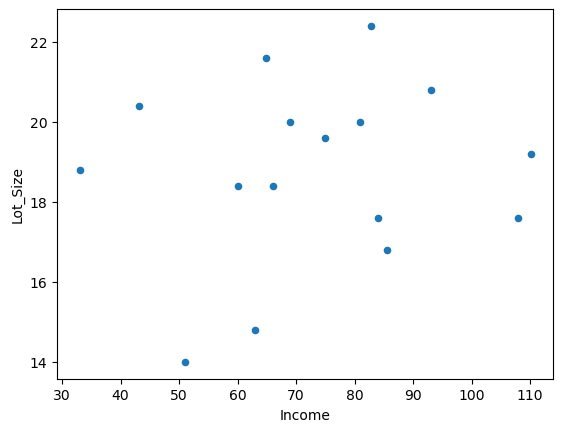

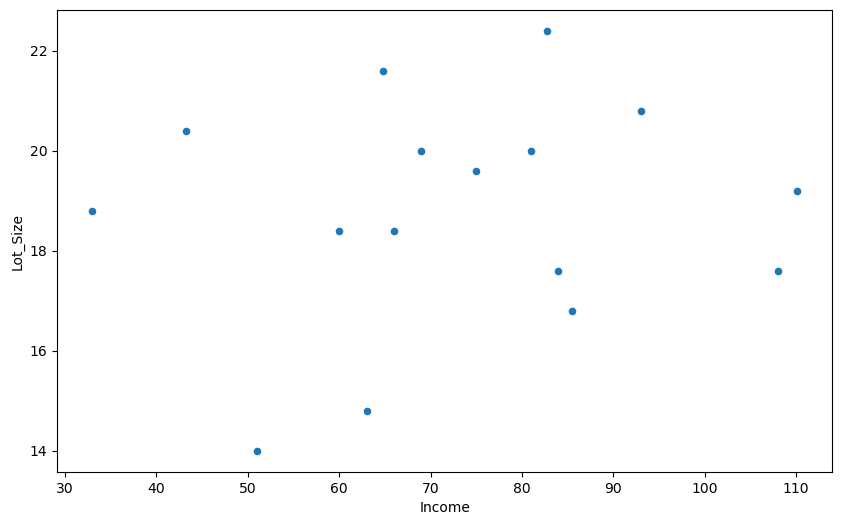

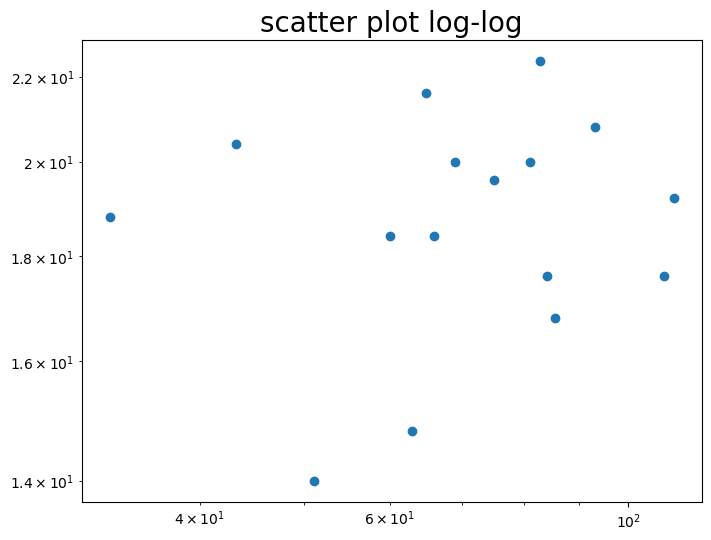

In [109]:
import matplotlib.pylab as plt # per i log serve matplotlib
fig = plt.figure(figsize=(8, 6))
plt.scatter(trainData['Income'],trainData['Lot_Size'])
plt.xscale("log")
plt.yscale("log")
plt.title("scatter plot log-log",fontsize=20)
plt.show()

In [110]:
# l'istogramma di Income (con pandas, nuovamente)
trainData.Income.hist()

<Axes: >

In [111]:
trainData.boxplot(column='Income',figsize=[12,8]) # sempre con pandas

<Axes: >

In [112]:
trainData.Income.describe()

count     16.000000
mean      73.087500
std       21.316437
min       33.000000
25%       62.250000
50%       72.000000
75%       84.375000
max      110.100000
Name: Income, dtype: float64

## Standardizzazione dei dati

In [113]:
scaler = preprocessing.StandardScaler()       # usiamo qui uno standardizzatore che usa la estimator API;
                                              # 'preprocessing.scale', usato nel primo nb, non la usava (era una funzione);
                                              # vedi 'help di 'StandardScaler'.

[StandardScaler vs scale](https://stackoverflow.com/questions/46257627/scikit-learn-preprocessing-scale-vs-preprocessing-standardscalar/46258260)

In [114]:
scaler.fit(trainData[['Income', 'Lot_Size']]) # Compute the mean and std-dev to be used for LATER scaling.
                                              # Sono la media e la std-dev dei dati di training.
                                              # 'fit' √® un tipico metodo della estimator API di scikit-learn.

# Da ISLR e DMforBA:
# Standardize features by removing the mean and scaling to unit variance. So, all variables are on a comparable scale.
# With standardization, we are expressing each value as the number of SD away from the mean (aka, z-score).

# The standard score of a sample x is calculated as:
# z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False (ie, not centered data),
# and s is the standard deviation of the training samples or one if with_std=False.

scaler

##########################################################################################################################
# --> Alcuni metodi di ML sono sensibili allo scaling (Regressione penalizzata, PCA, Clustering, ecc), cio√® producono    #
#     risultati differenti se i dati sono riscalati; per i CART √® consigliabile. Altri metodi sono insensibili           #
#     (Regressione Lineare OLS, nella quale la moltiplicazione di Xj per la costante c semplicemente riscala i           #
#     coefficienti stimati di 1/c, sicch√® il prodotto Xj*BetaJ rimane costante).                                         #
#     la regola del pollice, con i primi, √® di riscalare i dati se le unit√† di misura delle variabili sono differenti.   #
#     Se le unit√† di misura sono le stesse, o se la scala riflette l'importanza, non si standardizzano i dati, invece.   #
#     Per precauzione si pu√≤ riscalare sempre i dati.                                                                    #
##########################################################################################################################

StandardScaler()

In [115]:
# Transform the full dataset
mowerStd = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]), # concateno le prime due colonne
    columns=['zIncome', 'zLot_Size']),                                                 # (standardizzate) con le ultime due;
                                                                                       # la 'transform' utiliza mean/std
                                                                                       # calcolati prima dalla 'fit';
                                                                                       # la 'transform' √® un tipico metodo della
                                                                                       # estimator API di scikit-learn;
                                                                                       # z sta per normalizzato.
    mower_df[['Ownership', 'Number']]], axis=1)                                        # 'axis' = 1 (concateno colonne)
mowerStd

zIncome  zLot_Size Ownership  Number
0  -0.634098  -0.170642     Owner       1
1   0.601394  -0.898714     Owner       2
2  -0.401535   1.285503     Owner       3
3  -0.561422   0.921467     Owner       4
4   0.674070   2.195593     Owner       5
5   1.793280   0.193394     Owner       6
6   1.691534  -0.534678     Owner       7
7   0.470577   1.649539     Owner       8
8  -0.198042   0.557430     Owner       9
9   0.964774   0.921467     Owner      10
10 -1.070154   1.467521     Owner      11
11  0.383366   0.557430     Owner      12
12  0.092662   0.375412  Nonowner      13
13 -0.982943   0.921467  Nonowner      14
14 -0.401535  -0.716696  Nonowner      15
15 -1.448069   0.739448  Nonowner      16
16  0.528718  -0.534678  Nonowner      17
17 -1.157365  -0.534678  Nonowner      18
18 -0.663168  -1.262750  Nonowner      19
19 -0.343394  -0.170642  Nonowner      20
20 -1.244576  -1.080732  Nonowner      21
21 -1.942266   0.011376  Nonowner      22
22 -1.070154  -2.172841  Nonowner      23
23 -0.488746  -1.808805  Nonowner      24

In [116]:
preprocessing.scale(mower_df[['Income', 'Lot_Size']]) # standardizzazione con la funzione del primo nb.
                                                      # differenti!!

array([[-0.43545243, -0.23136968],
       [ 0.88058157, -0.9044451 ],
       [-0.18772838,  1.11478117],
       [-0.35803866,  0.77824346],
       [ 0.95799534,  1.95612545],
       [ 2.15016731,  0.10516804],
       [ 2.04178804, -0.56790739],
       [ 0.7412368 ,  1.45131888],
       [ 0.02903016,  0.44170575],
       [ 1.26765039,  0.77824346],
       [-0.89993501,  1.28305003],
       [ 0.64834028,  0.44170575],
       [ 0.33868522,  0.27343689],
       [-0.80703849,  0.77824346],
       [-0.18772838, -0.73617625],
       [-1.30248659,  0.6099746 ],
       [ 0.80316781, -0.56790739],
       [-0.99283153, -0.56790739],
       [-0.46641793, -1.24098281],
       [-0.12579737, -0.23136968],
       [-1.08572805, -1.07271396],
       [-1.82890019, -0.06310082],
       [-0.89993501, -2.08232709],
       [-0.2806249 , -1.74578938]])

**Normalizzazione vs Standardizzazione**:

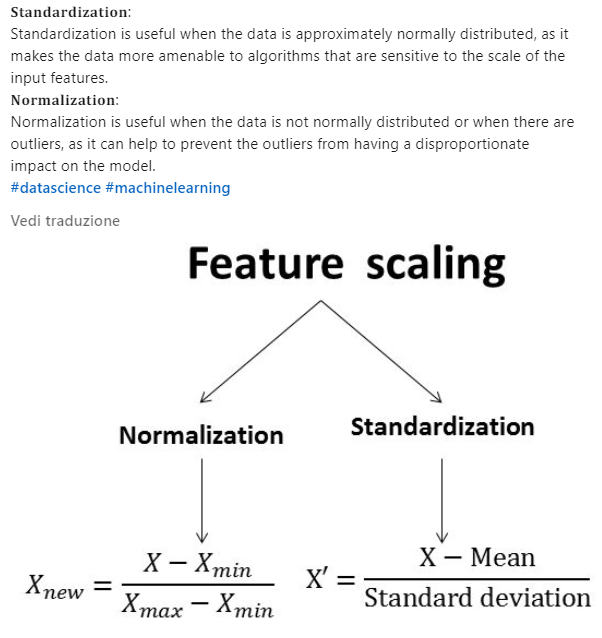

In [117]:
Image('std_norm.png') if IN_COLAB else display(Image(filename='std_norm.png'))

## Split del dataset

In [118]:
trainStd = mowerStd.iloc[trainData.index] # prendo gli indici del dataset di training originari e li uso per estrarre
                                          # un subset dei dati standardizzati.

validStd = mowerStd.iloc[validData.index] # la stessa operazione

newHouseholdStd = pd.DataFrame(scaler.transform(newHousehold), columns=['zIncome', 'zLot_Size'])
                                          # la 'transform' utiliza mean/std-dev calcolati prima dalla 'fit'

newHouseholdStd                           # x0

zIncome  zLot_Size
0 -0.634098    0.55743

## Applicazione del kNN

In [119]:
knn = NearestNeighbors(n_neighbors=3)  # step 1) costruzione dell'oggetto
                                       # 'metric'=minkowski con p=2 --> distanza euclidea.
                                       # la distanza euclidea √® la pi√π frequente nel knn ed √® computazionalmente veloce.
                                       # k esprime la regola di classificazione.
                                       # k=1 √® la scelta pi√π semplice --> il vicinato ad X0 √® semplicemente il punto pi√π vicino.

                                       # knn, ancorch√® semplice ed intuitivo, √® molto efficace quando il training set √® grande.
                                       # knn √® il miglior classificatore in un caso su tre (Hastie & Tibshirani).
                                       # l'errore di classificazione del knn √® al massimo due volte di quello se si conoscono
                                       # le PDF delle classi (cio√® le PDF congiunte condizionate ad ogni classe). Teorema.



[Distanza di Minkowski](https://it.wikipedia.org/wiki/Distanza_di_Minkowski#:~:text=In%20matematica%2C%20la%20distanza%20di,sia%20della%20distanza%20di%20Manhattan.)

In [120]:
knn.fit(trainStd[['zIncome', 'zLot_Size']])           # step 2) "fit" (nel knn √® solo uno store dei dati training)

distances, indices = knn.kneighbors(newHouseholdStd)  # step 3) previsione per nuovi dati (x0).
                                                      # "the method kneighbors finds the K-neighbors of a point. Returns indices
                                                      # of and distances to the neighbors of each point.""
                                                      # √® solo ora che knn lavora (algoritmo lazy!)

print(np.round(distances,2))                          # la distanza dei 3 punti del "vicinato" dal punto x0 (k=3).
                                                      # [gli altri punti del dataset hanno distanze da X0 maggiori].
print(indices)                                        # Gli indici dei punti del vicinato.
print(trainStd.index)

[[0.44 0.73 0.75]]
[[12  7 13]]
Index([2, 19, 6, 7, 21, 1, 16, 0, 15, 23, 22, 9, 8, 12, 11, 5], dtype='int64')


Come mai la famiglia pi√π vicina in assoluto a x0 √® la 12 e non la 13? Perch√® i dati sono stati (devono essere!) standardizzati. La dimensione 'Income' ha infatti una escursione di valori molto maggiore che la dimensione 'Lot_size'.

In [121]:
# verifichiamo ora che il vicinato ad X0 sia effettivamente tale!
# servono 6 passi.

# 1. creiamo un df pandas con tutte le osservazioni di training ed X0:
df_concat = pd.concat([trainStd[['zIncome', 'zLot_Size']],newHouseholdStd],axis=0)
                                                   # combina la colonna 1 dei casi 5 e 6 con la colonna 4 dei medesimi casi.
                                                   # 'axis' specifica la dimensione lungo la quale la concatenazione avviene.
                                                   # 0 righe - 1 colonne.

In [122]:
df_concat                                          # le righe di training ed al fondo la riga nuova

zIncome  zLot_Size
2  -0.401535   1.285503
19 -0.343394  -0.170642
6   1.691534  -0.534678
7   0.470577   1.649539
21 -1.942266   0.011376
1   0.601394  -0.898714
16  0.528718  -0.534678
0  -0.634098  -0.170642
15 -1.448069   0.739448
23 -0.488746  -1.808805
22 -1.070154  -2.172841
9   0.964774   0.921467
8  -0.198042   0.557430
12  0.092662   0.375412
11  0.383366   0.557430
5   1.793280   0.193394
0  -0.634098   0.557430

In [127]:
# verifichiamo ora che il vicinato ad X0 sia effettivamente tale!
# passi 2-6

# 2. pre-conversione di formato
X = df_concat[['zIncome', 'zLot_Size']].to_numpy() # la funxione 'dist.pairwise' (vedi step 3.) richiede un'array np.
                                                   # serve la conversione da pandas df a numpy array.
                                                   # '.to_numpy' converts specific columns of pandas df to numpy array
                                                   # (so 13187778).

# 3. calcoliamo la matrice delle distanze:
# Corrected import statement - DistanceMetric is in sklearn.metrics, not sklearn.neighbors
from sklearn.metrics import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

dist = dist.pairwise(X)            # la matrice delle distanze (euclidee) tra le osservazioni dell'array df_concat.
                                   # "'dist_pairwise' computes the pairwise distances between X (and Y). This is a
                                   # convenience routine for the sake of testing."

# 4. teniamo solo la matrice traingolare superiore (per chiarezza)
dist_lower = np.tril(dist)

# 5. con screen grandi si pu√≤ aumentare l'ampiezza di linea per avere output pi√π chiari:
np.set_printoptions(linewidth=110) # so 21971449, 37149933.

# 6. visualizziamola (con le sue dimensioni):
print(np.round(dist_lower,2),)
                                         # X0 √® l'ultima riga.
                                         # le tre distanze minori sono appunto 13,8,14 (in ordine crescente)
                                         #                        (con n-1 --> 12,7,13)

print(dist_lower.shape)                  # trainStd era 16x4, abbiamo aggiunto X0

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.46 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [2.77 2.07 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.95 1.99 2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [2.   1.61 3.67 2.92 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [2.4  1.19 1.15 2.55 2.7  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [2.04 0.95 1.16 2.18 2.53 0.37 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.47 0.29 2.35 2.13 1.32 1.43 1.22 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.18 1.43 3.39 2.12 0.88 2.62 2.35 1.22 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.1  1.64 2.53 3.59 2.33 1.42 1.63 1.64 2.72 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.52 2.13 3.21 4.12 2.35 2.1  2.29 2.05 2.94 0.69 0.   0.   0.   0.   0.   0.   0.  ]
 [1.41 1.7  1.63 0.88 3.05 1.86 

In [128]:
# nella suddetta matrice delle distanze, nella riga di X0 (l'ultima), il QUARTO valore crescente √® 0.76, alla posizione 1
# (indice 0).
# verifichiamolo con k=4 (con lo stesso codice di prima):
knn = NearestNeighbors(n_neighbors=4)
knn.fit(trainStd[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdStd)
print(np.round(distances,2))

print(indices)
print(trainStd.index)

[[0.44 0.73 0.75 0.76]]
[[12  7 13  0]]
Index([2, 19, 6, 7, 21, 1, 16, 0, 15, 23, 22, 9, 8, 12, 11, 5], dtype='int64')


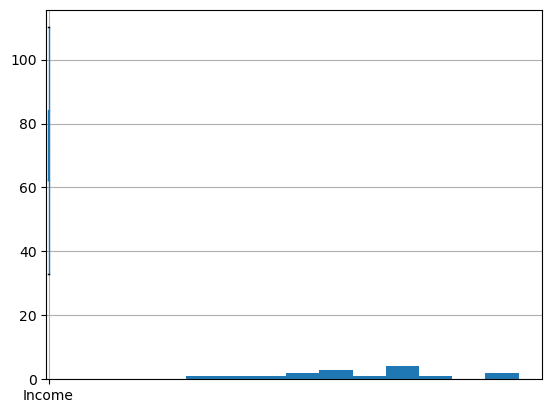

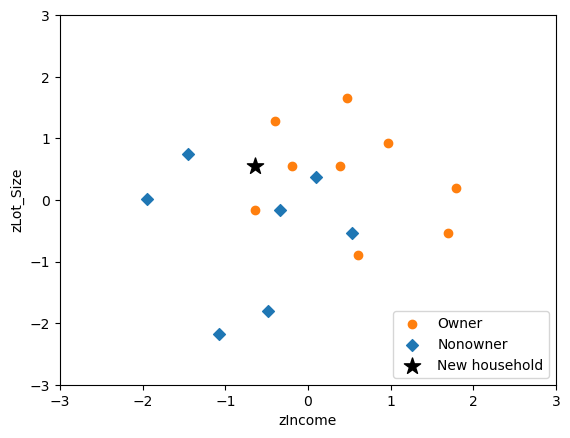

In [129]:
# lo scatter plot dei punti del training set e di X0 (con pandas).
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.zIncome, subset.zLot_Size, marker='o', label='Owner' if showLabel else None, color='C1', **kwargs)

    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.zIncome, subset.zLot_Size, marker='D', label='Nonowner' if showLabel else None, color='C0', **kwargs)

    plt.xlabel('zIncome')  # set x-axis label
    plt.ylabel('zLot_Size')  # set y-axis label
    # for _, row in data.iterrows():
    #    ax.annotate(row.Number, (row.zIncome + 2, row.zLot_Size))

fig, ax = plt.subplots()


plotDataset(ax, trainStd)

ax.scatter(newHouseholdStd.zIncome, newHouseholdStd.zLot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('zIncome')  # set x-axis label
plt.ylabel('zLot_Size')  # set y-axis label

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.legend(handles, labels, loc=4)

plt.show()

In [130]:
print(trainStd.iloc[indices[0], :])  # indices (il secondo output di 'knn.kneighbors') is a list of lists, we are only
                                     # interested in the first element

     zIncome  zLot_Size Ownership  Number
8  -0.198042   0.557430     Owner       9
0  -0.634098  -0.170642     Owner       1
12  0.092662   0.375412  Nonowner      13
2  -0.401535   1.285503     Owner       3


In [131]:
train_X = trainStd[['zIncome', 'zLot_Size']]
train_y = trainStd['Ownership']
valid_X = validStd[['zIncome', 'zLot_Size']]
valid_y = validStd['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1, 15): # k=1,2,...16
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results (a list) to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1     0.875
1    2     0.875
2    3     0.875
3    4     0.750
4    5     0.875
5    6     1.000
6    7     1.000
7    8     1.000
8    9     0.875
9   10     0.875
10  11     0.875
11  12     0.875
12  13     0.875
13  14     0.875


In [132]:
valid_y

13    Nonowner
18    Nonowner
3        Owner
14    Nonowner
20    Nonowner
17    Nonowner
10       Owner
4        Owner
Name: Ownership, dtype: object

In [133]:
# Retrain with full dataset
mower_X = mowerStd[['zIncome', 'zLot_Size']]
mower_y = mowerStd['Ownership']
knn = KNeighborsClassifier(n_neighbors=6).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdStd)
print(knn.predict(newHouseholdStd))
print('Distances',distances)
print('Indices', indices)
print(mowerStd.iloc[indices[0], :])

['Owner']
Distances [[0.37121978 0.43605598 0.50419739 0.72807232 0.74920667 0.76431337]]
Indices [[ 3  8 13  0 12  2]]
     zIncome  zLot_Size Ownership  Number
3  -0.561422   0.921467     Owner       4
8  -0.198042   0.557430     Owner       9
13 -0.982943   0.921467  Nonowner      14
0  -0.634098  -0.170642     Owner       1
12  0.092662   0.375412  Nonowner      13
2  -0.401535   1.285503     Owner       3


In [134]:
# Dall'importante Teorema di Cover & Hart (1967):
# L'error-rate (1-accuratezza) del classificatore 1-NN non √® asintoticamente mai maggiore di due volte il tasso di errore
# di Bayes.
# Cio√®, il tasso di errore di un classificatore che conosca il Decision Boundary, che cio√® conosca le probabilit√† di classe
# per ogni punto del dominio (detto appunto Bayes Error Rate) costituisce (per due) il limite superiore di 1-NN.

# La dissimilarit√† / distanza

Che distanze sono disponibili con knn? (argomento 'metric')<br>
Dalla documentazione: "The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric. <u>See the documentation of *DistanceMetric* for a list of available metrics."</u><br><br>
[Le distanze disponibili](https://scikit-learn.org/0.24/modules/generated/sklearn.neighbors.DistanceMetric.html).<br><br>
In particolare (per variabili continue):
* Euclidea
* Manhattan   (ad isolati)
* Mahalanobis (quella della gaussiana congiunta, tiene conto delle correlazioni)

**Quando la distanza euclidea non va bene?** Ecco un esempio commentato:<br>

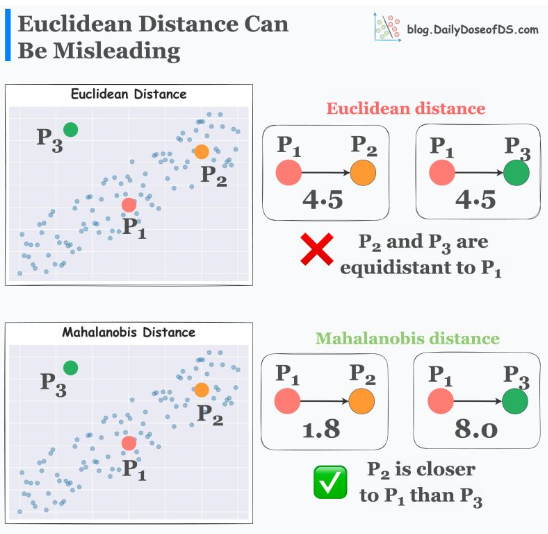

In [ ]:
Image('why_not_euclidean_distance2.png') if IN_COLAB else display(Image(filename='why_not_euclidean_distance2.png'))

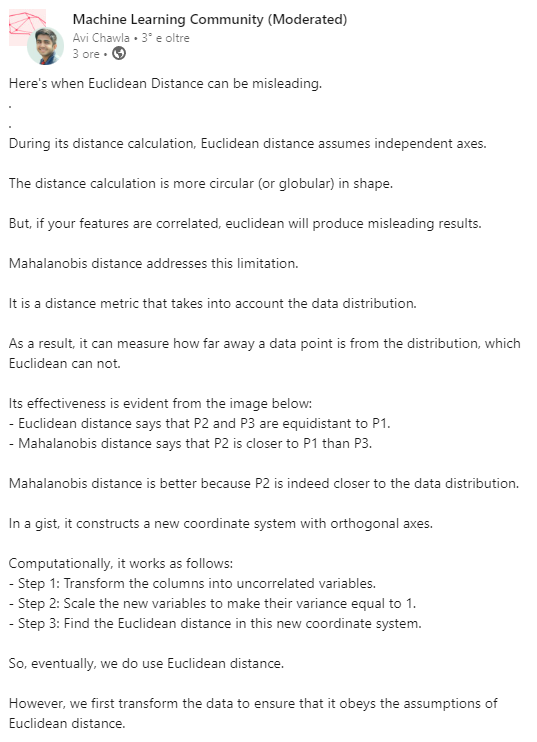

In [ ]:
Image('why_not_euclidean_distance.png') if IN_COLAB else display(Image(filename='why_not_euclidean_distance.png'))

**Segue un estratto dal testo "Applied Multivariate Statistical Analysis (sixth ed.) di Johnson & Wichern - 2014 <u>sulle Misure di similarit√†</u>:**<br>
![Misure di similarit√†](images_knn/MisureSimilaritaJW.png)
![Misure di similarit√†](images_knn/MisureSimilaritaJW2.png)
![Misure di similarit√†](images_knn/MisureSimilaritaJW3.png)
<br>

**Una distanza deve soddisfare alcune propriet√† (sempre dal testo di Johnson & Wichern, p. 37):**  
![Propriet√† delle distanze](images_knn/ProprietaDistanze.png)
<br><br>
UltraMetric (una quinta propriet√†) vs. Pseudo(Semi)Metric, che non soddisfa la "triangle inequality" (usate nella Text Analytics)
<br><br>

**Breve trattazione del tema similarit√† / dissimilarit√† / distanze (prof. Secchi, PoliMI, corso di "Applied Statistics" 2018):**
![Pagina 1](images_knn/DistanzeSecchi.png)
![Pagina 2](images_knn/DistanzeSecchi2.png)
![Pagina 3](images_knn/DistanzeSecchi3.png)
![Pagina 4](images_knn/DistanzeSecchi4.png)


[C'√® anche un libro: "Encyclopedia of distances" della Springer](https://link.springer.com/book/10.1007/978-3-642-30958-8)


# Il Decision Boundary

Come si **plotta** il Decision Boundary?

**L'algoritmo base di plotting** √® brevemente descritto in ESL, p. 110 (footnote):<br>
"(For this figure and many similar figures in the book) we compute the decision boundaries by an exhaustive contouring method.
We compute the decision rule on a fine lattice of points, and then use contouring algorithms to compute the boundaries.<br><br>
Di seguito sono forniti alcuni **codici python** che implementano questo algoritmo base (in modi leggermente differenti):

[Plot Python della famosa Figure 2.2 di ESL](https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib)

Nel DB le probabilit√† (per quel punto) delle due classi confinanti sono **uguali (o simili)**.<br>
Sono DB **stimati** tramite il campione. I veri DB non sono quasi mai noti (non √® noto il processo generativo dei dati).<br>

In [ ]:
# caricamento dei dati iris da internet (UCI Machine Learning)

import os
import pandas as pd

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

df.tail()

In [ ]:
# plot del dataset iris semplificato:
# - solo le due feature 'sepal length' e 'petal length'
# - solo i primi 100 fiori (corrispondenti alle due classi Setosa e Versicolor)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor (i primi 100 fiori)
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)       # coding delle due classi (setosa=0, Versicolor=1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')        # plot dei 50 fiori setosa
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')   # plot dei 50 fiori versicolor

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

In [ ]:
# split train/test di X e y (70% di 100 = 70; 30% di 100 = 30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=1)

# costruttore di un classificatore 3NN
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# fit sul training set
knn_classifier.fit(X_train,y_train)

# la previsione dei nuovi valori per i fiori di test
y_pred = knn_classifier.predict(X_test)

In [ ]:
# funzione di PLOTTING del DECISION BOUNDARY di Rashka (dal libro 'Machine Learning with PyTorch and Scikit-Learn', ch. 2:
# [https://github.com/rasbt/machine-learning-book/blob/main/ch02/ch02.ipynb]
# √® una funzione GENERALE, a prescindere dai dati in input e dal classificatore (che √® usato dalla funzione per plottare il
# colore di background dei punti della griglia: qui viola e rosa)

from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

In [ ]:
# il plot del DB
plot_decision_regions(X, y, classifier=knn_classifier)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

#plt.savefig('images/02_08.png', dpi=300)
plt.show()  # --> DB non-lineare

[Plot di due feature di iris (con matplotlib) usando 4 differenti classificatori: output e codice python](https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html)

# Tipi di classificazione

![Multi Class & Multi Output](images_knn/MultiClassMultiOutput.png)

[Maggiori info su MC & MO in scikit-learn](https://scikit-learn.org/stable/modules/multiclass.html).

# KNN per la regressione

In [100]:
df_car = pd.read_csv('ToyotaCorolla.csv')

In [101]:
df_car.head()

Id                                          Model  Price  Age_08_04  \
0   1  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13500         23   
1   2  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13750         23   
2   3  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13950         24   
3   4  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  14950         26   
4   5    TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors  13750         30   

   Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  ... Powered_Windows  \
0         10      2002  46986    Diesel  90          1  ...               1   
1         10      2002  72937    Diesel  90          1  ...               0   
2          9      2002  41711    Diesel  90          1  ...               0   
3          7      2002  48000    Diesel  90          0  ...               0   
4          3      2002  38500    Diesel  90          0  ...               1   

   Power_Steering  Radio  Mistlamps  Sport_Model  Backseat_Divider  \
0               1      0          0            0                 1   
1               1      0          0            0                 1   
2               1      0          0            0                 1   
3               1      0          0            0                 1   
4               1      0          1            0                 1   

   Metallic_Rim  Radio_cassette  Parking_Assistant  Tow_Bar  
0             0               0                  0        0  
1             0               0                  0        0  
2             0               0                  0        0  
3             0               0                  0        0  
4             0               0                  0        0  

[5 rows x 39 columns]

In [102]:
df_car.shape

(1436, 39)

In [103]:
df_car.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'],
      dtype='object')

In [104]:
df_car.dtypes

Id                    int64
Model                object
Price                 int64
Age_08_04             int64
Mfg_Month             int64
Mfg_Year              int64
KM                    int64
Fuel_Type            object
HP                    int64
Met_Color             int64
Color                object
Automatic             int64
CC                    int64
Doors                 int64
Cylinders             int64
Gears                 int64
Quarterly_Tax         int64
Weight                int64
Mfr_Guarantee         int64
BOVAG_Guarantee       int64
Guarantee_Period      int64
ABS                   int64
Airbag_1              int64
Airbag_2              int64
Airco                 int64
Automatic_airco       int64
Boardcomputer         int64
CD_Player             int64
Central_Lock          int64
Powered_Windows       int64
Power_Steering        int64
Radio                 int64
Mistlamps             int64
Sport_Model           int64
Backseat_Divider      int64
Metallic_Rim        

Verifichiamo se ci sono MV (cio√® NaN) e nel caso cancelliamo le righe con il metodo `dropna()`:

In [197]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1436 non-null   int64 
 1   Model              1436 non-null   object
 2   Price              1436 non-null   int64 
 3   Age_08_04          1436 non-null   int64 
 4   Mfg_Month          1436 non-null   int64 
 5   Mfg_Year           1436 non-null   int64 
 6   KM                 1436 non-null   int64 
 7   Fuel_Type          1436 non-null   object
 8   HP                 1436 non-null   int64 
 9   Met_Color          1436 non-null   int64 
 10  Color              1436 non-null   object
 11  Automatic          1436 non-null   int64 
 12  CC                 1436 non-null   int64 
 13  Doors              1436 non-null   int64 
 14  Cylinders          1436 non-null   int64 
 15  Gears              1436 non-null   int64 
 16  Quarterly_Tax      1436 non-null   int64 


In [105]:
 # Consideriamo solo 10 predittori (ad esempio in base alla nostra esperienza): 
predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC','Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'   # risposta √® numerica --> problema di previsione numerica (cio√® di regressione)

df_car[predictors]  # subsetting di colonna

Age_08_04     KM Fuel_Type   HP  Met_Color  Automatic    CC  Doors  \
0            23  46986    Diesel   90          1          0  2000      3   
1            23  72937    Diesel   90          1          0  2000      3   
2            24  41711    Diesel   90          1          0  2000      3   
3            26  48000    Diesel   90          0          0  2000      3   
4            30  38500    Diesel   90          0          0  2000      3   
...         ...    ...       ...  ...        ...        ...   ...    ...   
1431         69  20544    Petrol   86          1          0  1300      3   
1432         72  19000    Petrol   86          0          0  1300      3   
1433         71  17016    Petrol   86          0          0  1300      3   
1434         70  16916    Petrol   86          1          0  1300      3   
1435         76      1    Petrol  110          0          0  1600      5   

      Quarterly_Tax  Weight  
0               210    1165  
1               210    1165  
2               210    1165  
3               210    1165  
4               210    1170  
...             ...     ...  
1431             69    1025  
1432             69    1015  
1433             69    1015  
1434             69    1015  
1435             19    1114  

[1436 rows x 10 columns]

In [109]:
df_car[predictors].dtypes

Age_08_04         int64
KM                int64
Fuel_Type        object
HP                int64
Met_Color         int64
Automatic         int64
CC                int64
Doors             int64
Quarterly_Tax     int64
Weight            int64
dtype: object

La variabile `Fuel_Type` √® categorica (`object` perch√® non riconosciuta come categorica dalla funzione `pd.read_csv`) e richiede quindi di essere dummizzata:

In [106]:
X = pd.get_dummies(df_car[predictors], drop_first=True)   
y = df_car[outcome]

In [107]:
X.shape

(1436, 11)

In [108]:
X.head()

Age_08_04     KM  HP  Met_Color  Automatic    CC  Doors  Quarterly_Tax  \
0         23  46986  90          1          0  2000      3            210   
1         23  72937  90          1          0  2000      3            210   
2         24  41711  90          1          0  2000      3            210   
3         26  48000  90          0          0  2000      3            210   
4         30  38500  90          0          0  2000      3            210   

   Weight  Fuel_Type_Diesel  Fuel_Type_Petrol  
0    1165              True             False  
1    1165              True             False  
2    1165              True             False  
3    1165              True             False  
4    1170              True             False

In [110]:
std_X = preprocessing.scale(X)             # la funzione 'scale' fa SIA centering CHE rescaling;
                                           # notare i 3 booleani a True per default.
                                           # usa uno stimatore BIASED della dev.std. Dall'help in linea, infatti:
                                           # "We use a biased estimator for the standard deviation, equivalent to
                                           # 'numpy.std(x, ddof=0). Note that the choice of 'ddof' is unlikely to
                                           # affect model performance."
                                           # la funzione 'scale' NON ha l'argomento 'ddof'!

print(std_X)                               # --> standardizzare significa prendere le SD come unit√† di misura.
                                           #    le prime due righe hanno age 67 e 22 --> 2.76645648 e -1.19140394
display(X)                                   # per confronto

# il calcolo manuale di un elemento (come verifica): l'et√† delprimo cliente
# (67 - X['Age'].mean()) / X['Age'].std()

[[-1.77196633 -0.57469494 -0.76804185 ...  1.75856113  2.87480715
  -2.71087388]
 [-1.77196633  0.11745379 -0.76804185 ...  1.75856113  2.87480715
  -2.71087388]
 [-1.71818412 -0.71538641 -0.76804185 ...  1.75856113  2.87480715
  -2.71087388]
 ...
 [ 0.80957948 -1.37403589 -1.03513832 ... -1.09191497 -0.34784942
   0.36888474]
 [ 0.75579727 -1.37670303 -1.03513832 ... -1.09191497 -0.34784942
   0.36888474]
 [ 1.0784905  -1.82784925  0.5674405  ...  0.78939926 -0.34784942
   0.36888474]]


Age_08_04     KM   HP  Met_Color  Automatic    CC  Doors  Quarterly_Tax  \
0            23  46986   90          1          0  2000      3            210   
1            23  72937   90          1          0  2000      3            210   
2            24  41711   90          1          0  2000      3            210   
3            26  48000   90          0          0  2000      3            210   
4            30  38500   90          0          0  2000      3            210   
...         ...    ...  ...        ...        ...   ...    ...            ...   
1431         69  20544   86          1          0  1300      3             69   
1432         72  19000   86          0          0  1300      3             69   
1433         71  17016   86          0          0  1300      3             69   
1434         70  16916   86          1          0  1300      3             69   
1435         76      1  110          0          0  1600      5             19   

      Weight  Fuel_Type_Diesel  Fuel_Type_Petrol  
0       1165              True             False  
1       1165              True             False  
2       1165              True             False  
3       1165              True             False  
4       1170              True             False  
...      ...               ...               ...  
1431    1025             False              True  
1432    1015             False              True  
1433    1015             False              True  
1434    1015             False              True  
1435    1114             False              True  

[1436 rows x 11 columns]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    std_X, y, test_size=0.25, random_state=10)                     # non usiamo pi√π l'argomento 'stratify' (si usa solo con la classificazione)

In [112]:
print("X_train: ", X_train.shape,type(X_train))       # --> una array numpy 2D
print("X_test: ", X_test.shape,type(X_test))          # --> una array numpy 2D
print("y_train: ", y_train.shape,type(y_train))       # --> una serie pandas 1D (non sottoposta prima a standardizzazione)
print("y_test: ", y_test.shape,type(y_test))          # --> una serie pandas 1D (non sottoposta prima a standardizzazione)

X_train:  (1077, 11) <class 'numpy.ndarray'>
X_test:  (359, 11) <class 'numpy.ndarray'>
y_train:  (1077,) <class 'pandas.core.series.Series'>
y_test:  (359,) <class 'pandas.core.series.Series'>


In [113]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)

In [114]:
knn_regressor.fit(X_train,y_train)

KNeighborsRegressor()

$R^2$ ha senso con KNN, ma solo sul test dataset.

In [115]:
y_pred = knn_regressor.predict(X_test) # la previsione dei nuovi valori

In [118]:
y_pred

array([ 8140. , 10220. ,  7770. , 12680. , 10200. , 12370. , 11166. ,
        7980. , 15940. ,  9140. ,  9779. , 10450. ,  9819. , 13336. ,
       16240. , 12560. ,  7484. , 16640. , 12680. ,  8590. ,  9367. ,
        7730. ,  8980. ,  8060. ,  8670. ,  8979.8, 10540. ,  7355. ,
        8460. , 18510. , 12800. ,  7790. , 12628. , 10740. ,  8300. ,
        8810. ,  9020. , 11720. , 11359. ,  8529. ,  9820. ,  7570. ,
       15660. ,  9809.8, 12960. , 11959. , 12079. ,  9100. ,  8589. ,
        6570. , 20750. ,  9550. ,  8779. , 19020. , 10650. ,  7530. ,
        8450. , 26485. , 10250. ,  9900. ,  8700. ,  7480. ,  8520. ,
        8300. ,  8590. ,  7960. ,  7470. , 16919. , 12367. , 18663.6,
       10510. ,  9870. , 16240. ,  9510. , 18080. , 21300. , 11219. ,
       17530. , 11308. , 10299. ,  8270. , 20260. ,  7750. , 12160. ,
       11610. , 20200. , 10450. ,  8730. , 17639.8,  9520. , 11800. ,
       10280. ,  9580. ,  8700. , 16140. ,  9350. ,  9440. , 17490. ,
        7030.2,  765

La metrica principale per valutare la qualit√† predittiva (di test) dell'algoritmo √® il **Rooted Mean Square Error**, vedi [qui](https://en.wikipedia.org/wiki/Root_mean_square_deviation), dato dalla seguente formula:

$$\mathrm{RMSE_{test}}=\sqrt{\frac{\sum_{n=1}^{N_{test}}\left(y_n-\hat{y}_n\right)^2}{N_{test}}}$$


In [119]:
regressionSummary(y_test,y_pred)  


Regression statistics

                      Mean Error (ME) : 110.2267
       Root Mean Squared Error (RMSE) : 1211.5952
            Mean Absolute Error (MAE) : 948.8786
          Mean Percentage Error (MPE) : -0.4239
Mean Absolute Percentage Error (MAPE) : 9.0875


La funzione `regressionSummary` calcola le metriche pi√π comuni (sul test). Quella pi√π utilizzata √® l'RMSE.

Il modello fa un errore previsionale medio di **1211 euro**. L'RMSE serve sia a capire l'errore medio in termini pratici sia a confrontare modelli diversi sugli stessi dati. Pi√π basso RMSE √®, meglio √®.<br>

Nella classificazione l'inevitabile incertezza del ML predittivo era espressa con le probabilit√† di classe. Nella regressione essa √® espressa tramite gli intervalli di confidenza.
Come calcolare un **intervallo di confidenza** di questa stima puntuale? In vari modi:
- con il **bootstrap**
- in modo **analitico**

In [120]:
# in modo analitico:
import numpy as np
from math import sqrt
z = 1.96

s = (y_test - y_pred)**2
mse_hat = s.mean()
se_mse  = s.std(ddof=1) / sqrt(len(s))

mse_L = max(0.0, mse_hat - z*se_mse)
mse_U = mse_hat + z*se_mse
ci_rmse = (sqrt(mse_L), sqrt(mse_U))
ci_rmse

(1088.1625430324505, 1323.566467176119)

Cio√®, RMSE nel 95% dei casi (per futuri campioni di righe) sar√† compreso tra 1088 e 1323. La stima puntuale (se vogliamo un solo valore) √® 1211.

# Grafici
Nel corso useremo prevalentemente la grafica di pandas.

La libreria di Data Visualization pi√π vecchia √® 'matplotlib'. E' anche la pi√π flessibile. <br>

Sulla differenza tra il modulo *pylab* ed il modulo *pyplot*, entrambi di matplotlib, vedi [qui](https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot).<br>
[Ed anche qui](https://queirozf.com/entries/matplotlib-pylab-pyplot-etc-what-s-the-different-between-these): --> l'uso di pylab √® ora <u>scoraggiato</u>.

Diverse librerie costruiscono un wrapper sopra di esse, ad es. pandas e seaborn.

seaborn ha le heatmap, utili per visualizzare le correlazioni ed i missing values.

Una buona conoscenza di matplotlib permette un controllo pi√π fine del plot finale, ma √® oltre lo scopo del corso.

Un'alternativa ancora √® ggplot, costruita sulla "grammatica della grafica" di Leland Wilkinson.



In [84]:
# il grafico iris con matplotlib (senza commento codice):

fig, ax = plt.subplots()

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='Owner', color='C1')

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner', color='C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
for _, row in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='Owner' if showLabel else None, color='C1', **kwargs)

    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner' if showLabel else None, color='C0', **kwargs)

    plt.xlabel('Income')  # set x-axis label
    plt.ylabel('Lot_Size')  # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots()

plotDataset(ax, trainData)
plotDataset(ax, validData, showLabel=False, facecolors='none')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

In [ ]:
# come ingrandire questo plot? (so 36367986)

# fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # non funziona

# in modo permanentem (FUNZIONA):
# plt.rcParams['figure.figsize'] = [12, 8]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Campionamento

In [ ]:
mower_df.sample(5,random_state=1)

In [ ]:
# Regole pratiche?! (DMforBA, p. 29)
# 10 righe per ogni predittore;
# per classificazione: 6 * m * p (m= numero delle etichette della classe, p = numero delle feature)

# Knn approssimato
![knn approssimato](images_knn\approximated_KNN.png)

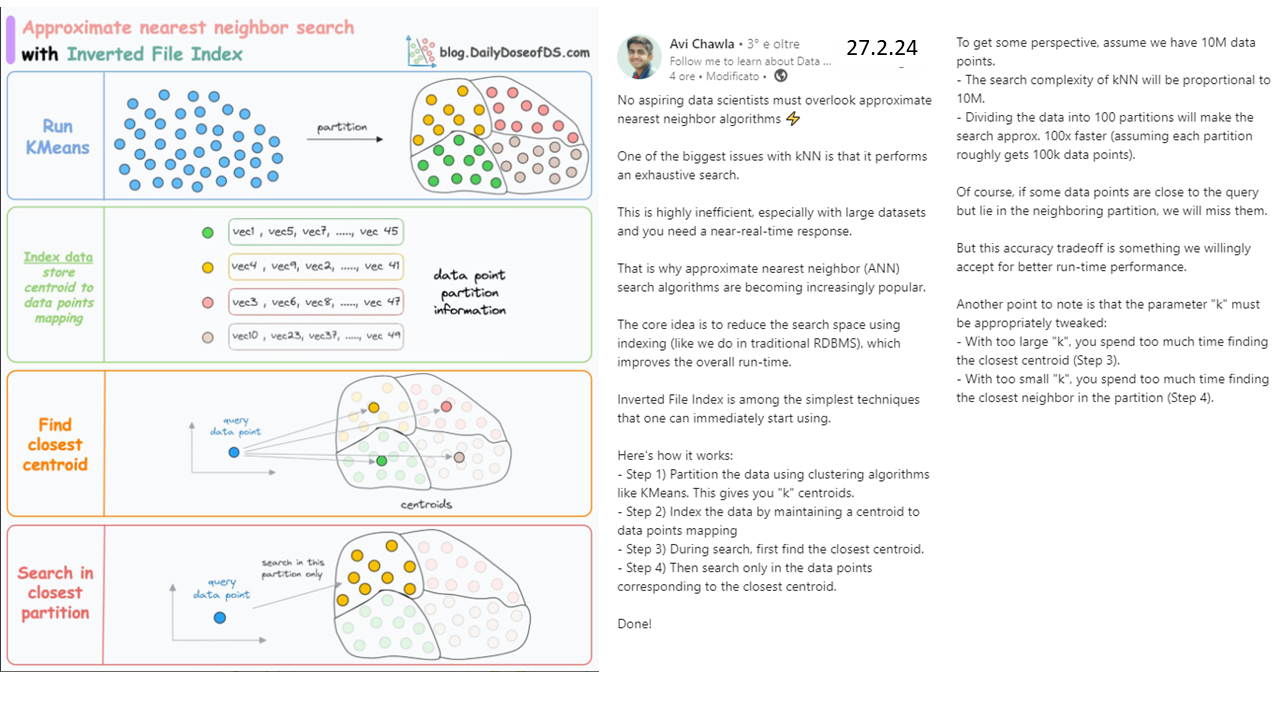

In [ ]:
Image('approximated_KNN.png') if IN_COLAB else display(Image(filename='images_knn/approximated_KNN.png'))

# KNN con classi sbilanciate
Da [questo post](https://www.linkedin.com/posts/avi-chawla_heres-how-i-use-knns-on-a-highly-imbalanced-activity-7196817136160272384-gV8d?utm_source=share&utm_medium=member_desktop) di Avi Chawla.

Here's how I use kNNs on a highly imbalanced dataset.

One of the things that always makes me a bit cautious and skeptical when using kNN is its HIGH sensitivity to the parameter <k>.

Recently, I used it for multi-class classification and this was the class distribution:
‚Ü≥ Class A: 188 samples
‚Ü≥ Class B: 49 samples
‚Ü≥ Class C: 23 samples
‚Ü≥ Class D: 4 samples
‚Ü≥ Class E: 3 samples

The problem we face in such an imbalanced dataset is that if we set <k> to:
- Any value greater than 7, we can NEVER classify a test instance to "class E."
- Any value greater than 9, we can NEVER classify a test instance to "class D" and "class E."

This is because traditional kNN relies on majority voting.

One intuitive solution is to set a low value of <k> (say, 3 or 4).

However, I have consistently noticed that this leads to suboptimal performance with other (majority/semi-majority) classes because the model can not holistically evaluate the nearest neighbor patterns.

In my project, I used two techniques to address this (can be used together if you wish to).

First technique was to dynamically update the hyperparameter <k>.

Here's how it works:

Step 1) Find the <k> nearest neighbors as usual.

Step 2) Update the value of the k as follows:
‚Ü≥ For all "unique classes" that appear in the <k> nearest neighbor, find the total instances they have. Let's say there are two unique classes, with 40 and 3 instances, respectively.
‚Ü≥ Update the value of k to <k' = min(k, 40, 3)>

Step 3) Now perform majority voting only on the first <k'> neighbors only.

This makes an intuitive sense as well:

- If a minority class appears in the top <k> nearest neighbor, we must reduce the value of k so that the majority class does not dominate.
- If a minority class DOES NOT appears in the top k nearest neighbor, we can safely proceed with a holistic classification.



In [ ]:
from IPython.display import IFrame
IFrame("Two Simple Yet Immensely Powerful Techniques to Supercharge kNN Models.pdf", width=1000, height=600)

# Learning on the fly from massive datasets with *river*

Da [*Banias Baabe*](https://www.linkedin.com/in/banias/).

Do you want ML models that learn on-the-fly from massive datasets?

Try ùê´ùê¢ùêØùêûùê´.

ùê´ùê¢ùêØùêûùê´ is a library for online machine learning.

You can continuously update your model with streaming data without using the full dataset for training again.

It provides online implementations for many algorithms like KNN, Tree-based models and Recommender systems.

![](river.png)

# Breathing KMeans
The convergence of KMeans depends on the centroids you begin with.
Thus, obtaining inaccurate clusters is highly likely.

Repeating the algorithm with a different initialization usually helps. But it introduces an unnecessary overhead in run-time.

I have found Breathing KMeans to be a much better algorithm...
...both in terms of producing better clustering results and lower run-time.

If you prefer a more visual explanation, read this: https://lnkd.in/gDWYyvy8.

There are five intuitive steps:

1) Run KMeans (once) with <k> centroids (don't repeat the algo with a different initialization).

2) Breathe in step:
- Add <m> new centroids to the <k> centroids obtained above.
- Place them in the vicinity of centroids with high error.
- Intuitively speaking, if a centroid has a high error, multiple clusters might be associated with it. So, it would be better to split this cluster. Adding new centroids near high-error ones will fulfill this objective.
- Run KMeans (once) with <k+m> centroids.

3) Breathe out step:
- Remove <m> centroids from <k+m> centroids obtained above.
- Which ones to remove is decided based on the ‚Äúutility‚Äù of a centroid.
- A centroid‚Äôs utility is proportional to its distance from all other centroids. The greater the distance, the more isolated it will be. Hence, the more the utility.
- On the flip side, If two centroids are pretty close, they will have low utility. Thus, they will likely be in the same cluster, and we must remove one of them.
- Remove all <m> low-utility centroids this way. This gives back <k> centroids.
- Run KMeans (once) with <k> centroids.

4) Decrease m by 1.

5) Repeat steps 2-3 until m=0.

In my experience, these repeated cycles of breathe-in and breathe-out steps almost always provides a faster and better solution than standard KMeans with repetitions.

In each cycle:
- New centroids are added at ‚Äúgood‚Äù locations. This helps in splitting clusters occupied by a single centroid.
- Low-utility centroids are removed. This helps eliminate centroids that are likely in the same cluster.

As a result, it converges to the optimal solution faster.

The effectiveness of Breathing KMeans over KMeans is evident from the image below.

There is also an open-source implementation of Breathing KMeans with a sklearn-like API.

You can find the code here: https://lnkd.in/gDWYyvy8.
    
![](breathing_Kmeans.png)

# Confronto di modelli di classificazione di `scikit-learn` con *Taipy*
Con questa **framework Python open-source** si possono costruire <u>app interattive full-stack</u>.<br>
Questa **demo** confronta differenti modelli di classificazione di `scikit-learn` ed i relativi *decision region plots*, .
![](Taipy_slide.png)
<br><br>
[Link](https://www.linkedin.com/posts/paulocr2_find-which-ml-model-works-best-on-your-data-activity-7276978141732999168-L1h6/) al post di Linkedin di Akshay Pachaar, cofounder di Daily Dose of Data Science, con il **post animato** (i *decision region plots*).
<br><br>
[Link](https://blog.dailydoseofds.com/p/taipy-scikit-learn-app) al post di Akshay Pachaar con il **codice Python**.
<br><br>
Nella directory di questo notebook sono disponibili anche:
* il PPT `Taipy_slide` con i link attivi
* i due file PDF: `Taipy` e `Taipy2`.